In [1]:
# Importing libraries ---------------------------------------------------------- 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm' 
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 300
# Read dataset ----------------------------------------------------------------- 
df = pd.read_csv('Combined_Flights_2018.csv', usecols=['Origin', 'Dest', 'Cancelled', 'CRSDepTime', 'DepDelay', 'CRSElapsedTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek', 'IATA_Code_Operating_Airline', 'CRSArrTime', 'ArrDelay', 'ArrivalDelayGroups'])
# Data preprocessing ----------------------------------------------------------- 
# drop cancelled flights 
df_col = df.loc[df['Cancelled'] == False]
df_col = df_col.drop('Cancelled', axis=1)
# copy the dataset
df_raw = df_col.copy() 
# simplify column names 
df_col.rename(columns = {'CRSDepTime': 'DepTime', 'CRSElapsedTime': 'ElapsedTime','DayOfWeek': 'DayofWeek', 'IATA_Code_Operating_Airline': 'Airline', 'CRSArrTime': 'ArrTime', 'ArrivalDelayGroups':'ArrGroup'}, inplace = True)
df_raw.rename(columns = {'CRSDepTime': 'DepTime', 'CRSElapsedTime': 'ElapsedTime','DayOfWeek': 'DayofWeek', 'IATA_Code_Operating_Airline': 'Airline', 'CRSArrTime': 'ArrTime', 'ArrivalDelayGroups':'ArrGroup'}, inplace = True)
# Drop one level of one-hot encoded columns to avoid multicollinearity 
origin = pd.get_dummies(df_col['Origin'], prefix='origin', drop_first=True)
dest = pd.get_dummies(df_col['Dest'], prefix='dest', drop_first=True)
month = pd.get_dummies(df_col['Month'], prefix='month', drop_first=True)
day_m = pd.get_dummies(df_col['DayofMonth'], prefix='day_m', drop_first=True)
day_w = pd.get_dummies(df_col['DayofWeek'], prefix='day_w', drop_first=True)
airline = pd.get_dummies(df_col['Airline'], prefix='airline', drop_first=True)

# drop original columns
df_col = df_col.drop(columns=['Origin', 'Dest', 'Month', 'DayofMonth', 'DayofWeek', 'Airline'])
# combine dataset together 
df_new = pd.concat([df_col, origin], axis=1)
df_new = pd.concat([df_new, dest], axis=1)
df_new = pd.concat([df_new, month], axis=1)
df_new = pd.concat([df_new, day_m], axis=1)
df_new = pd.concat([df_new, day_w], axis=1)
df_new = pd.concat([df_new, airline], axis=1)

### Numerical data 
# Convert 24h-formatted time to minutes 
def time_to_minutes(time_24h):
    """Convert 24h-formatted time to minutes."""
    return (time_24h // 100) * 60 + (time_24h % 100)

df_new['DepTime'] = df_new['DepTime'].apply(time_to_minutes)
df_new['ArrTime'] = df_new['ArrTime'].apply(time_to_minutes)


'''
We will do the normalization and standardization after splitting the dataset. 
This is to avoid data leakage. 
'''

# Drop rows with NaN values 
df_new.dropna(inplace=True) 
df_raw.dropna(inplace=True)

print(df.columns, df.shape)
print(df_raw.columns, df_raw.shape)
print(df_new.columns, df_new.shape)

Before dropping NaN values, df_new has 5601139 rows.
Before dropping NaN values, df_raw has 5601139 rows.
Index(['Origin', 'Dest', 'Cancelled', 'CRSDepTime', 'DepDelay',
       'CRSElapsedTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek',
       'IATA_Code_Operating_Airline', 'CRSArrTime', 'ArrDelay',
       'ArrivalDelayGroups'],
      dtype='object') (5689512, 14)
Index(['Origin', 'Dest', 'DepTime', 'DepDelay', 'ElapsedTime', 'Distance',
       'Month', 'DayofMonth', 'DayofWeek', 'Airline', 'ArrTime', 'ArrDelay',
       'ArrGroup'],
      dtype='object') (5585544, 13)
Index(['DepTime', 'DepDelay', 'ElapsedTime', 'Distance', 'ArrTime', 'ArrDelay',
       'ArrGroup', 'origin_ABI', 'origin_ABQ', 'origin_ABR',
       ...
       'airline_OH', 'airline_OO', 'airline_PT', 'airline_QX', 'airline_UA',
       'airline_VX', 'airline_WN', 'airline_YV', 'airline_YX', 'airline_ZW'],
      dtype='object', length=819) (5585544, 819)


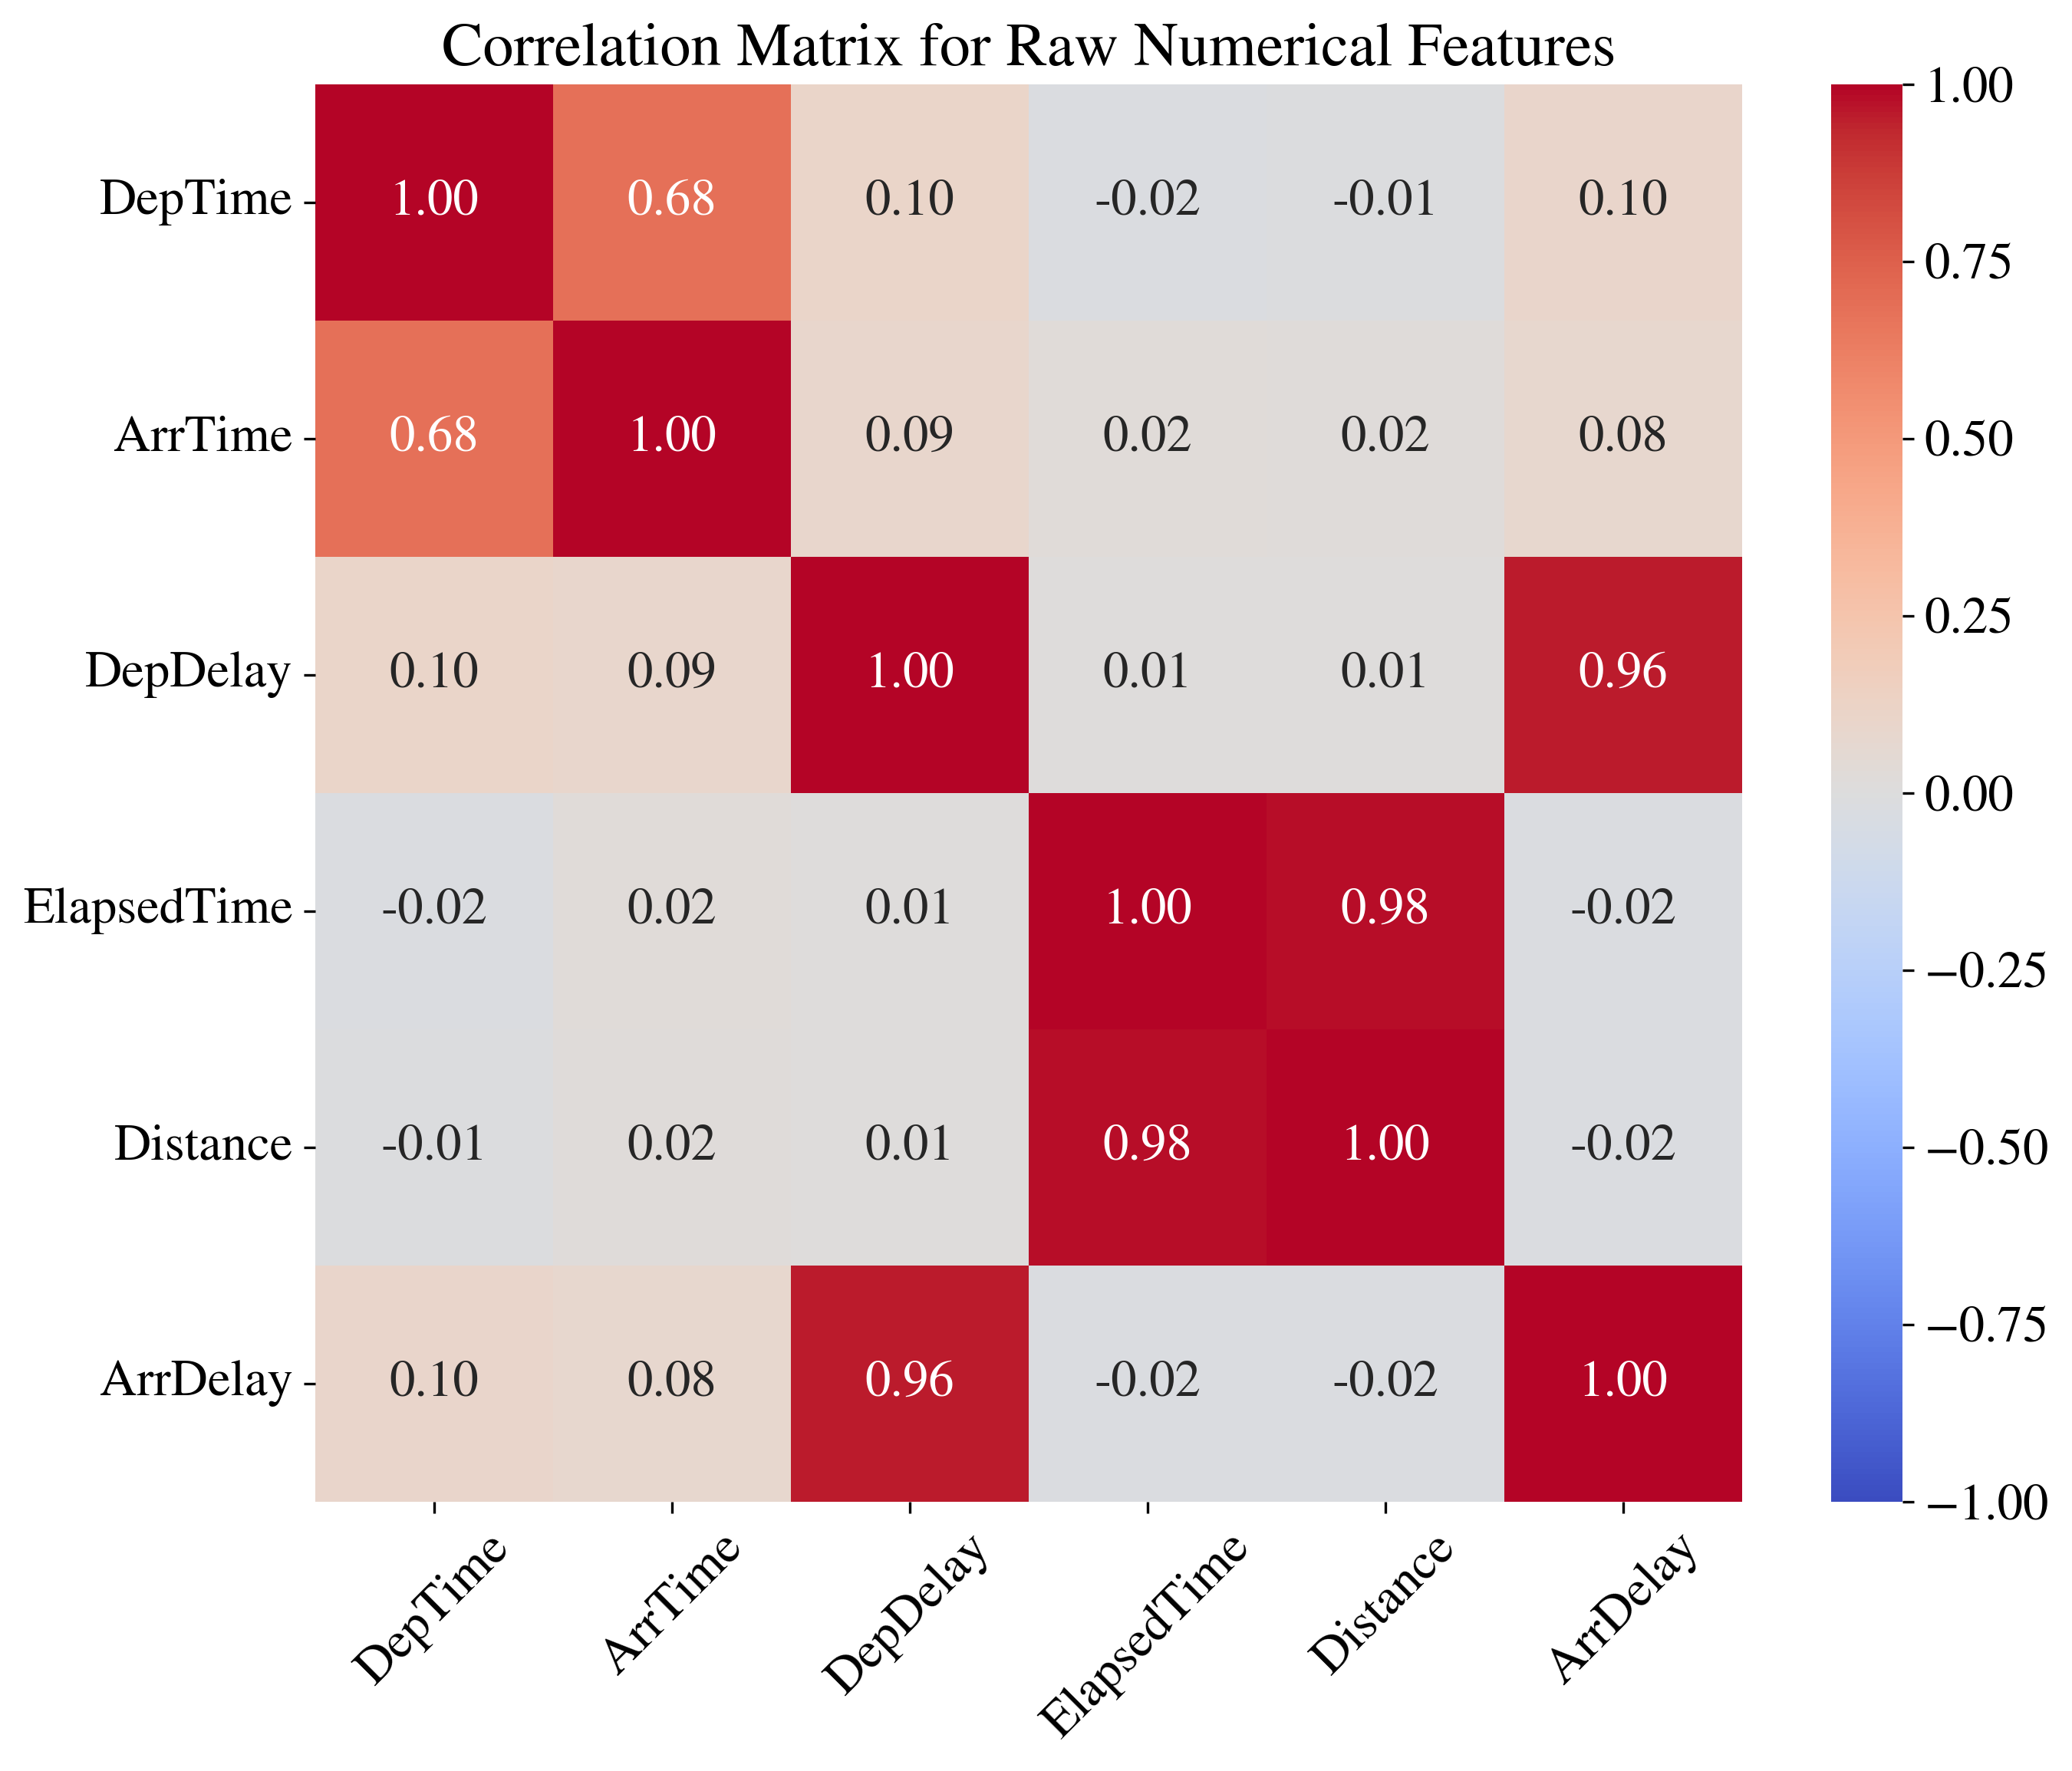

In [9]:
### Correlation matrix for numerical data 

# Raw numerical data ----------------------------------------------------------- 
numerical_features = ['DepTime', 'ArrTime', 'DepDelay', 'ElapsedTime', 'Distance', 'ArrDelay'] 

# Select subset 
numerical_data = df_new[numerical_features] 
# Calculate the correlation matrix
corr_matrix = numerical_data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Raw Numerical Features')
plt.xticks(ticks=plt.xticks()[0], rotation=45)
plt.show()

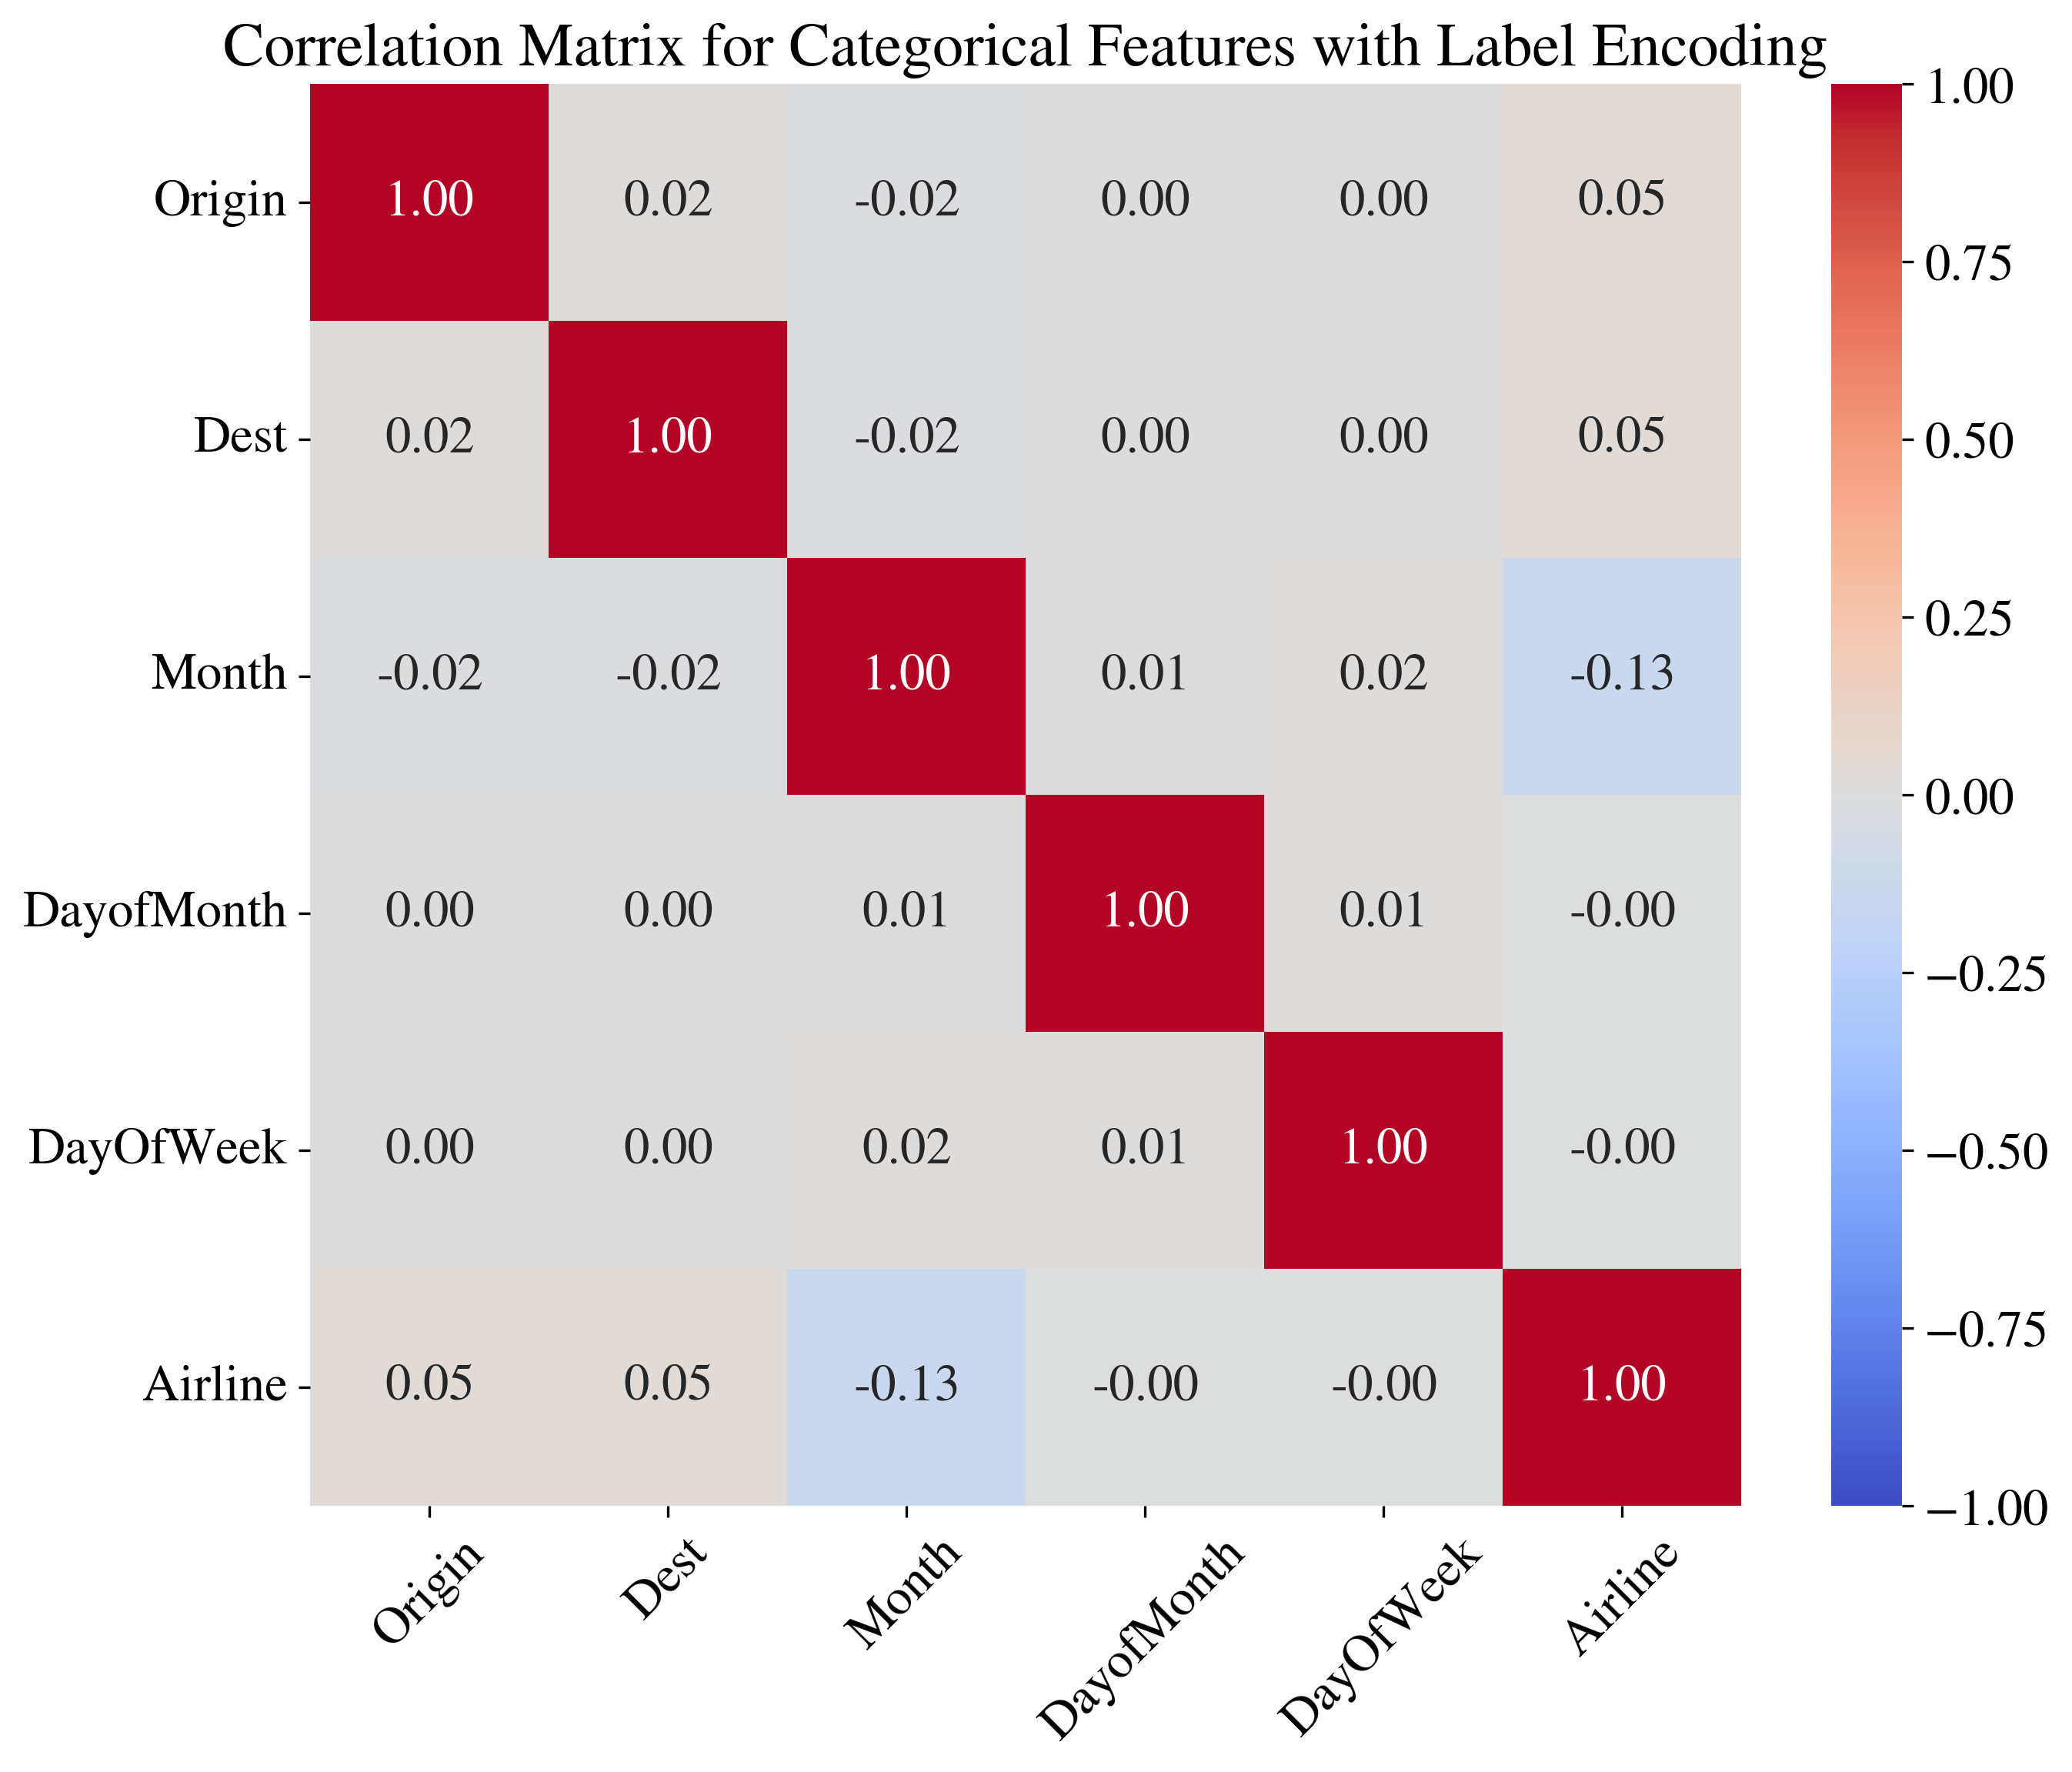

In [8]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical variables 
categorical_features = ['Origin', 'Dest', 'Month', 'DayofMonth', 'DayOfWeek', 'IATA_Code_Operating_Airline']

# Make a copy of the original DataFrame for safety
df_categorical = df[categorical_features].copy()

# Apply Label Encoding
label_encoder = LabelEncoder()
for col in categorical_features:
    df_categorical[col] = label_encoder.fit_transform(df[col])

# Calculate the correlation matrix
corr_matrix_categorical = df_categorical.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_categorical, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Categorical Features with Label Encoding')

labels = [label if label != 'IATA_Code_Operating_Airline' else 'Airline' for label in df_categorical.columns]
plt.xticks(ticks=plt.xticks()[0], labels=labels, rotation=45)
plt.yticks(ticks=plt.yticks()[0], labels=labels, rotation=0)
plt.show()


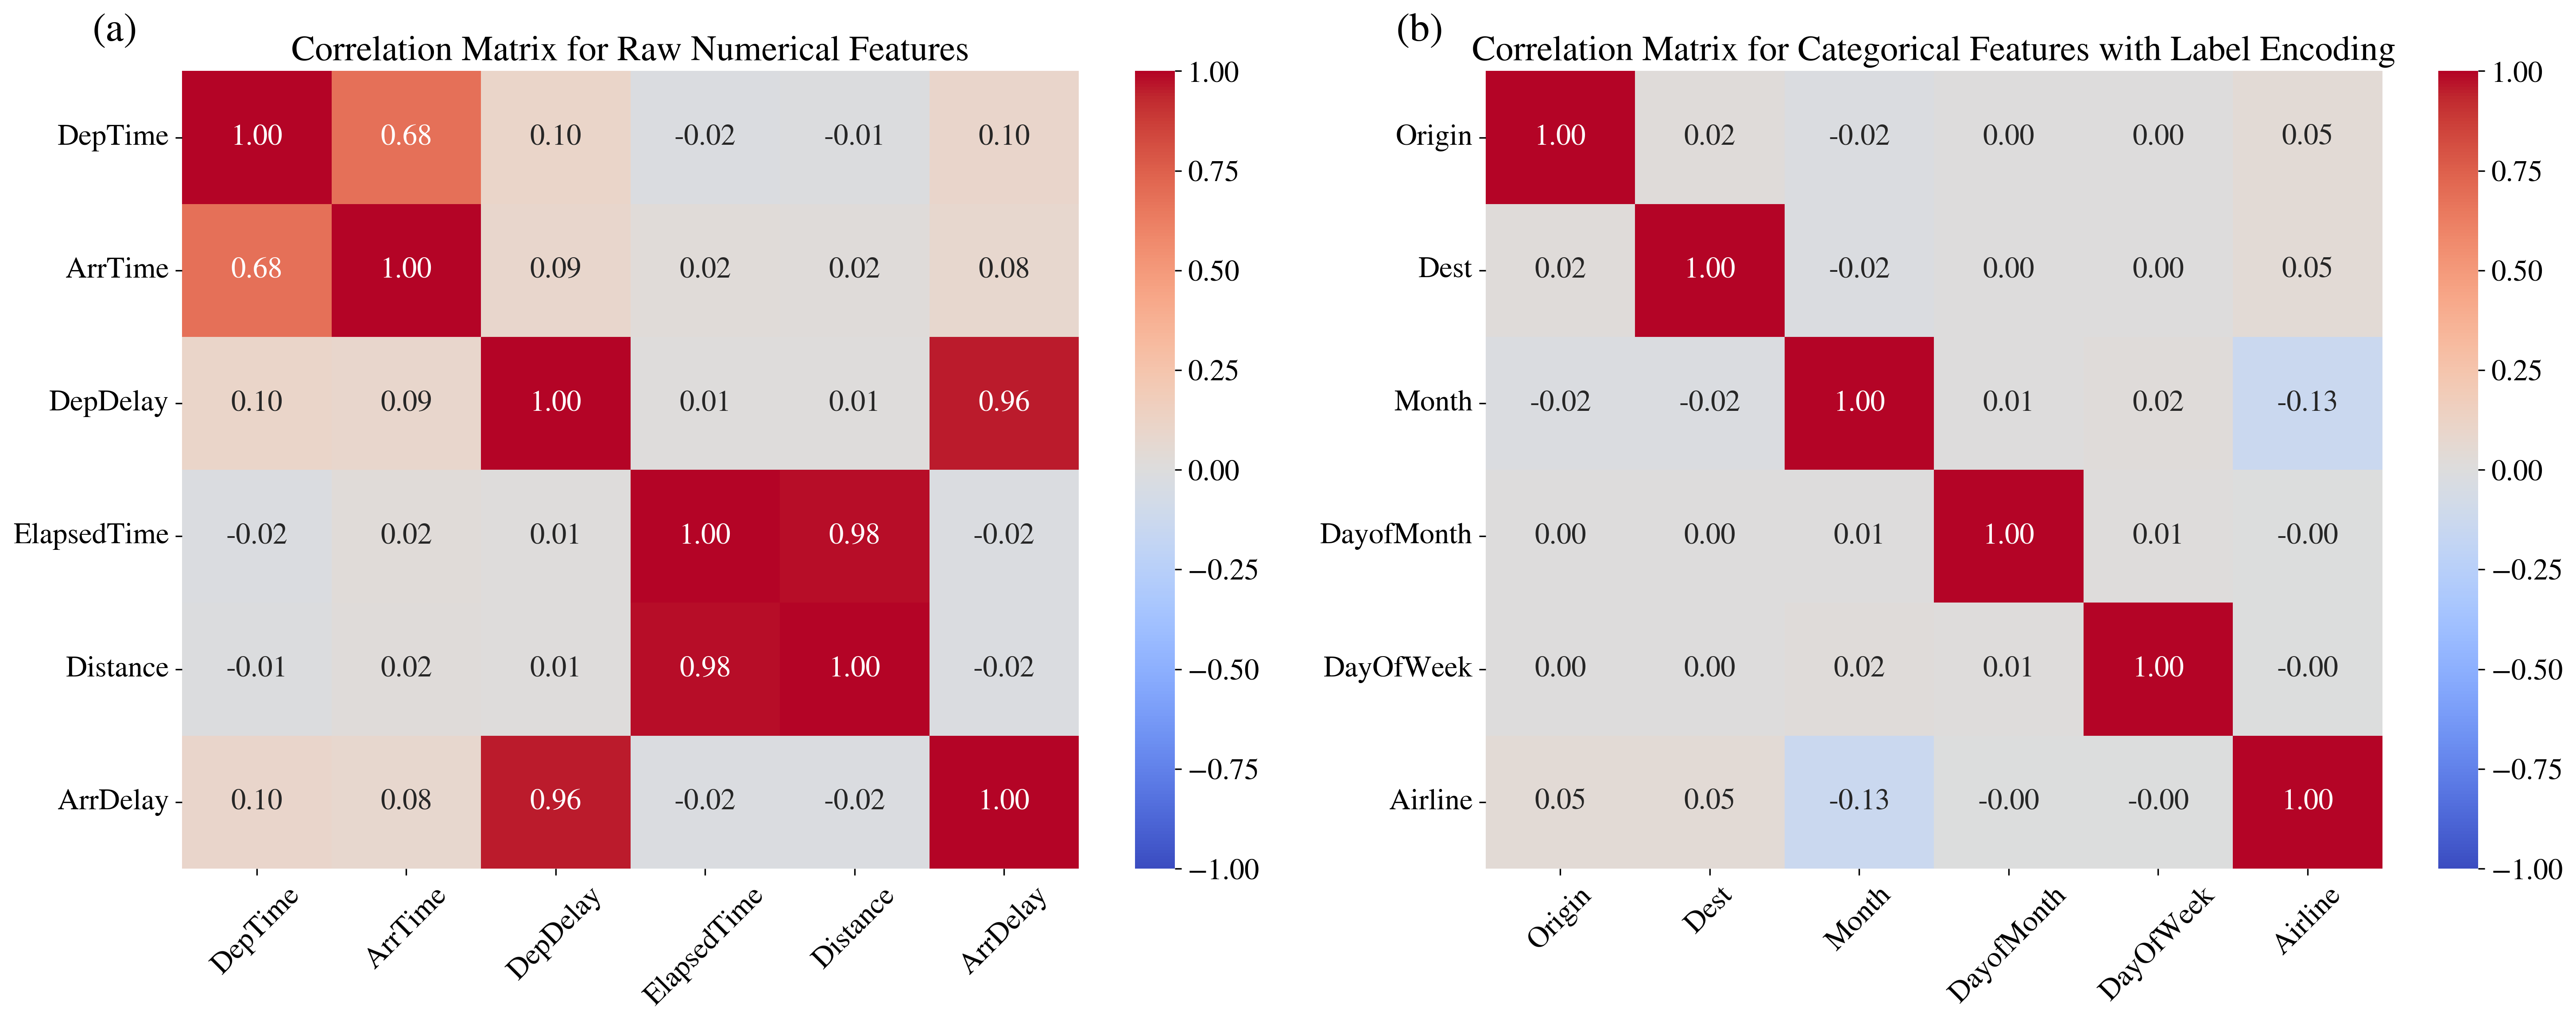

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Raw numerical data 
numerical_features = ['DepTime', 'ArrTime', 'DepDelay', 'ElapsedTime', 'Distance', 'ArrDelay']
numerical_data = df_new[numerical_features]
corr_matrix = numerical_data.corr()

# Identify categorical variables 
categorical_features = ['Origin', 'Dest', 'Month', 'DayofMonth', 'DayOfWeek', 'IATA_Code_Operating_Airline']
df_categorical = df[categorical_features].copy()

# Apply Label Encoding
label_encoder = LabelEncoder()
for col in categorical_features:
    df_categorical[col] = label_encoder.fit_transform(df[col])
corr_matrix_categorical = df_categorical.corr()
labels = [label if label != 'IATA_Code_Operating_Airline' else 'Airline' for label in df_categorical.columns]

# Create a single figure with two subplots side-by-side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8)) 

# Numerical features 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax[0])
ax[0].set_title('Correlation Matrix for Raw Numerical Features')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(numerical_features, rotation=45)
ax[0].text(-0.1, 1.05, '(a)', transform=ax[0].transAxes, fontsize=22, va='center')

# Categorical features with label encoding 
sns.heatmap(corr_matrix_categorical, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax[1])
ax[1].set_title('Correlation Matrix for Categorical Features with Label Encoding')
ax[1].set_xticks(ax[1].get_xticks())
ax[1].set_xticklabels(labels, rotation=45)
ax[1].set_yticklabels(labels, rotation=0)
ax[1].text(-0.1, 1.05, '(b)', transform=ax[1].transAxes, fontsize=22, va='center')

plt.tight_layout()
plt.show()

In [5]:
### Correlation Map for Processed Data --- This is gonna take several hours to run 
# Calculate correlation matrix for processed data
corr_matrix_processed = df_new.corr()

# Plot heatmap for processed data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_processed, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Map - Processed Data')
plt.show()


# Split data

In [6]:
# Split the data into features and target
X = df_new.drop(columns=['ArrDelay', 'ArrGroup']) # drop the target variable for regression (ArrDelay) and classification (ArrGroup)
y = df_new['ArrDelay']

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Now, split the training data into training and validation sets (89% training, 11% validation of the original dataset)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

# Separate numerical and categorical columns
numerical_columns = ['DepTime', 'ArrTime', 'DepDelay', 'ElapsedTime', 'Distance']
categorical_columns = X_train.columns.difference(numerical_columns)

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Fit and transform the scalers on the training data, then transform the validation and test data
# For normalization
X_train_norm = X_train.copy()
X_val_norm = X_val.copy()
X_test_norm = X_test.copy()

X_train_norm[numerical_columns] = minmax_scaler.fit_transform(X_train[numerical_columns])
X_val_norm[numerical_columns] = minmax_scaler.transform(X_val[numerical_columns])
X_test_norm[numerical_columns] = minmax_scaler.transform(X_test[numerical_columns])

# For standardization
X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_val_std[numerical_columns] = standard_scaler.transform(X_val[numerical_columns])
X_test_std[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

# Normalize and standardize target variable 
y_train_norm = minmax_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_norm = minmax_scaler.transform(y_val.values.reshape(-1, 1))
y_test_norm = minmax_scaler.transform(y_test.values.reshape(-1, 1))

y_train_std = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_std = standard_scaler.transform(y_val.values.reshape(-1, 1))
y_test_std = standard_scaler.transform(y_test.values.reshape(-1, 1))


# Feature Selection 

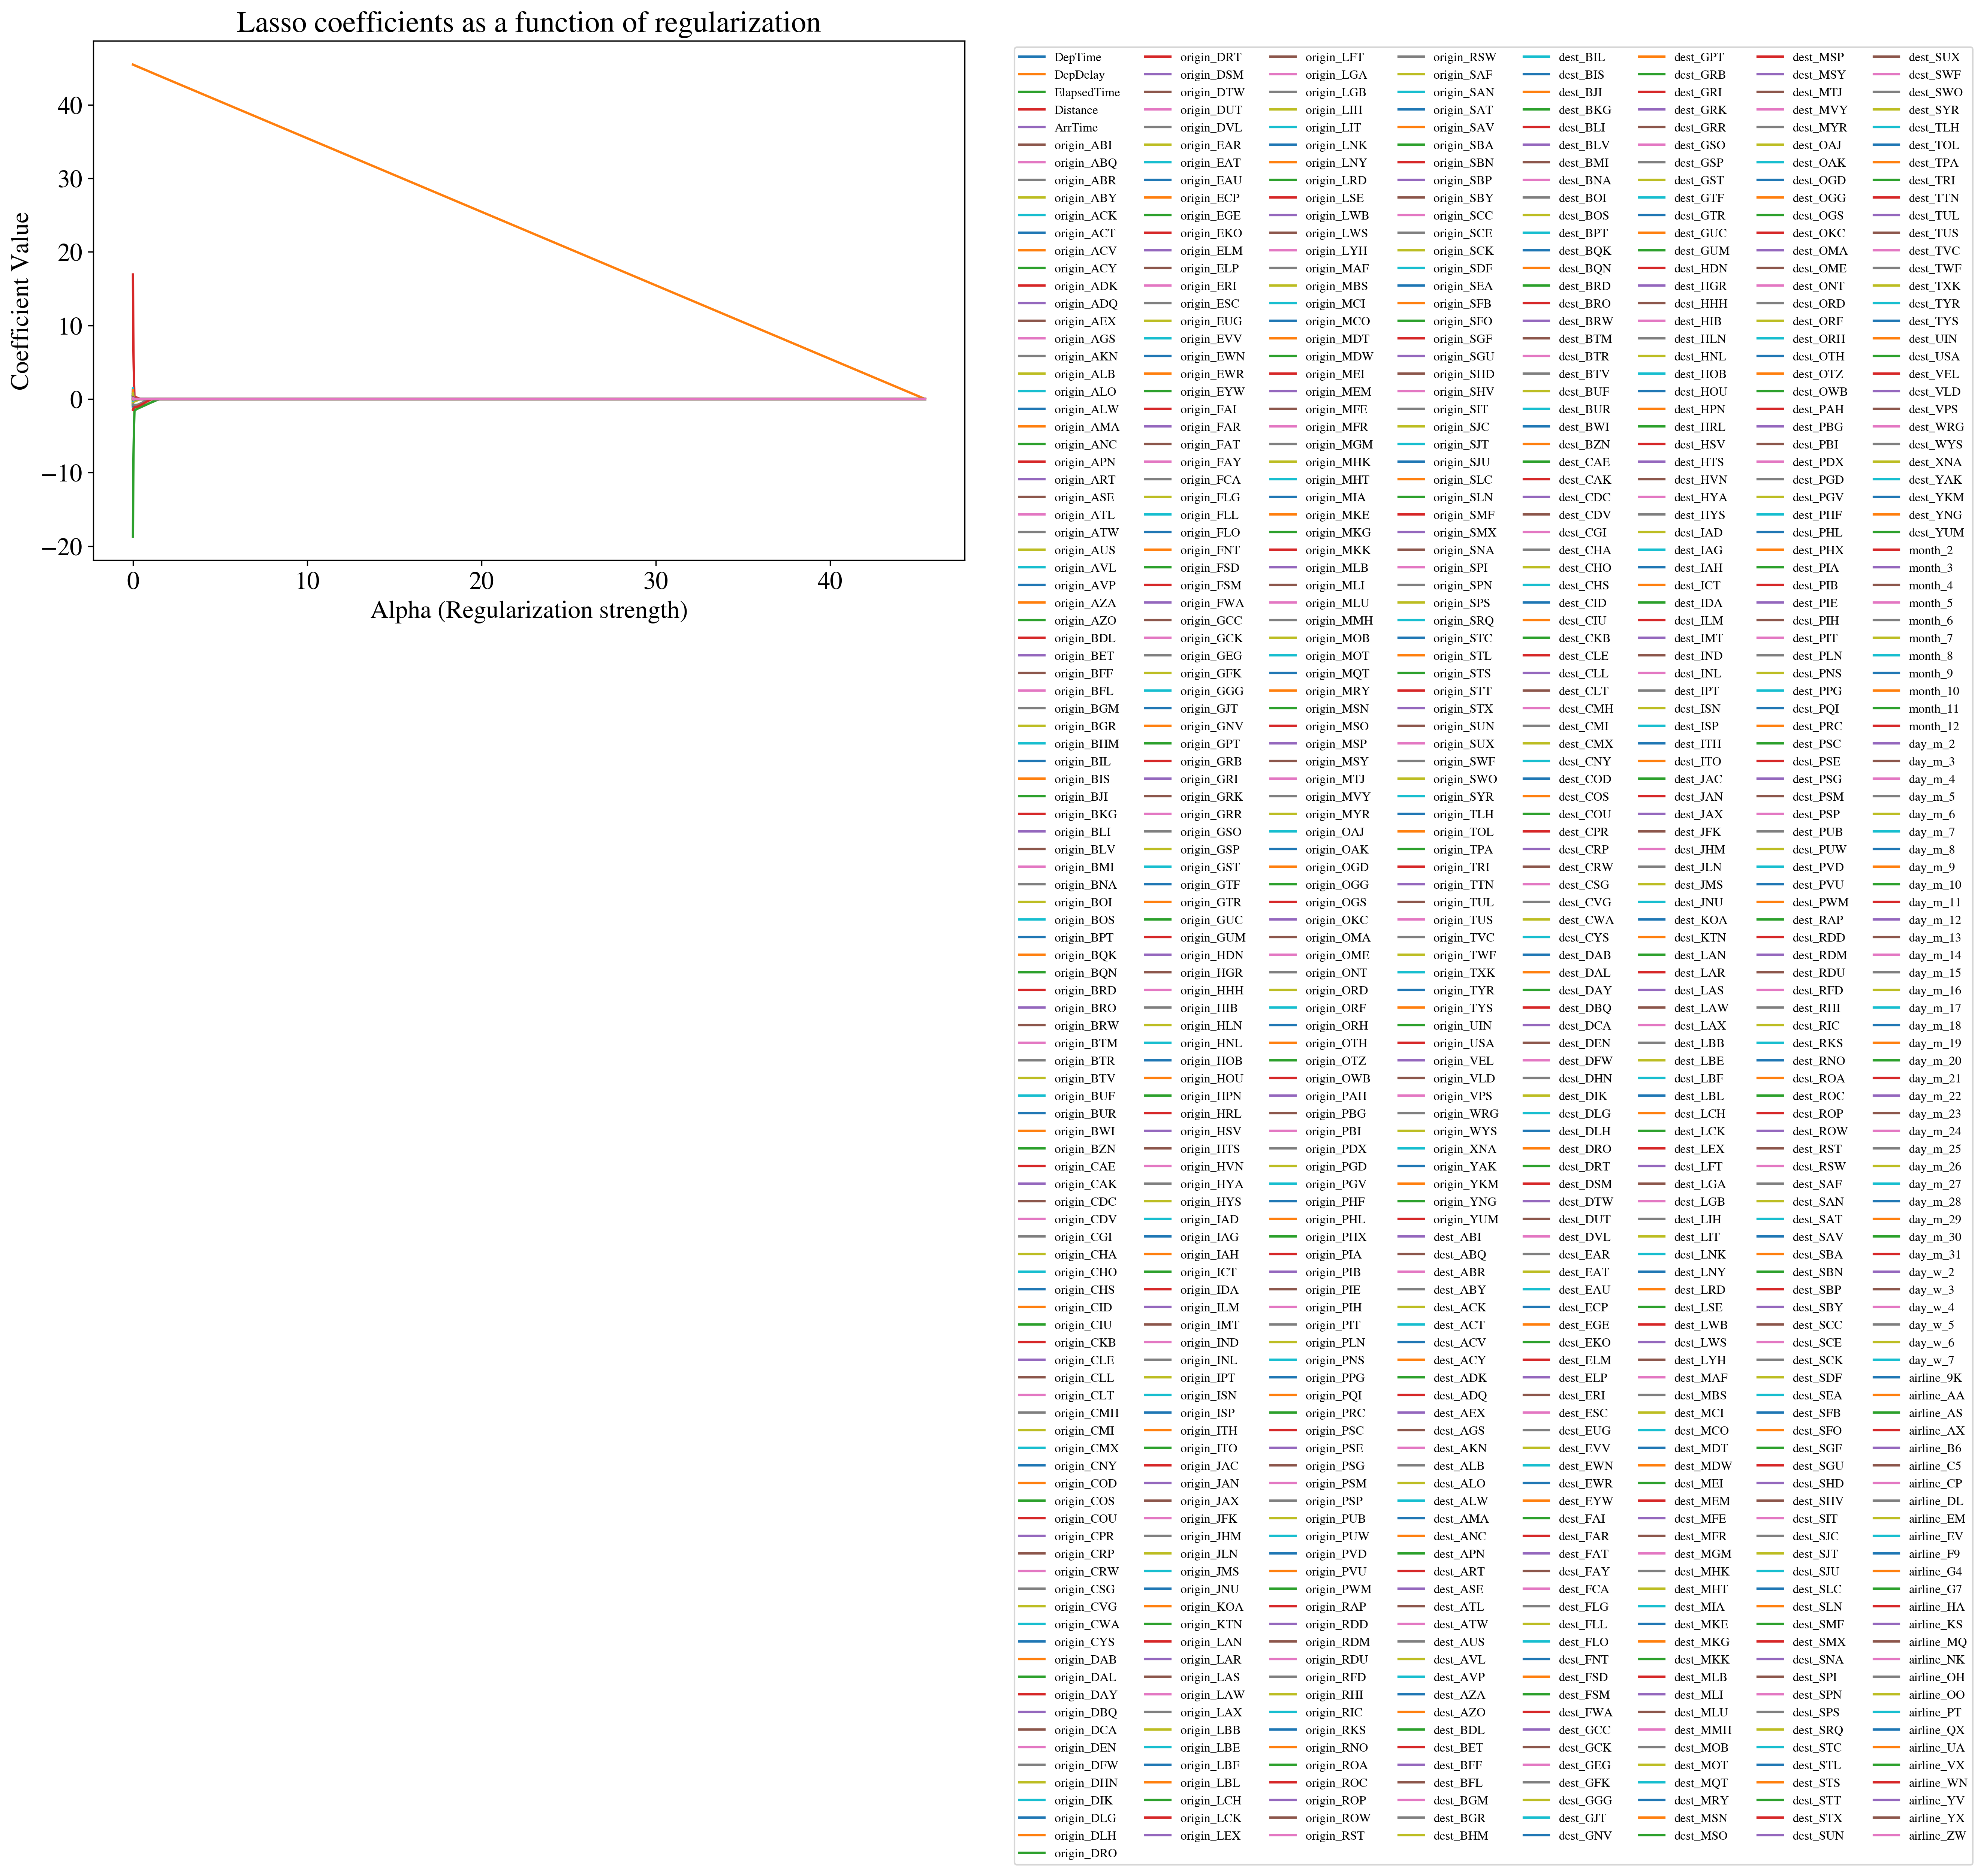

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_std, y_train.values.ravel(), eps=1e-6, max_iter=10000, tol=0.01)

# Display results
plt.figure(figsize=(10, 6))

for coef_l, feature in zip(coefs_lasso, X_train.columns):
    plt.plot(alphas_lasso, coef_l, label=feature)

plt.xlabel('Alpha (Regularization strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a function of regularization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=8, fontsize=8)
plt.axis('tight')

plt.show()

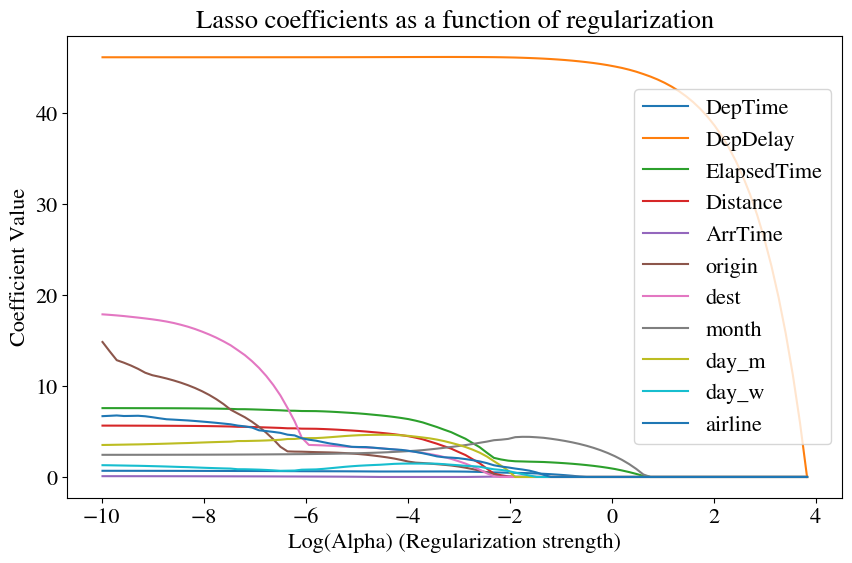

In [20]:
# Group categorical columns by type and then take the mean of the coefficients for each group

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler

# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_std, y_train.values.ravel(), eps=1e-6, max_iter=10000, tol=0.01)

# Create a DataFrame to make manipulation easier
coefs_df = pd.DataFrame(coefs_lasso, index=X_train.columns)

# Function to simplify labels
def simplify_label(label):
    parts = label.split('_')
    if len(parts) > 1:
        if 'day_m' in label or 'day_w' in label:
            return f"{parts[0]}_{parts[1]}"
        else:
            return f"{parts[0]}"
    return label

# Simplify labels
simplified_labels = coefs_df.index.to_series().apply(simplify_label).unique()

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through simplified labels to plot the paths
for label in simplified_labels:
    label_coefs = coefs_df.filter(regex=f'^{label}', axis=0)
    mean_coef_path = np.abs(label_coefs).max(axis=0)
    plt.plot(np.log(alphas_lasso), mean_coef_path, label=label)

# Customize plot
plt.xlabel('Log(Alpha) (Regularization strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a function of regularization')
plt.legend()
plt.axis('tight')

plt.show()

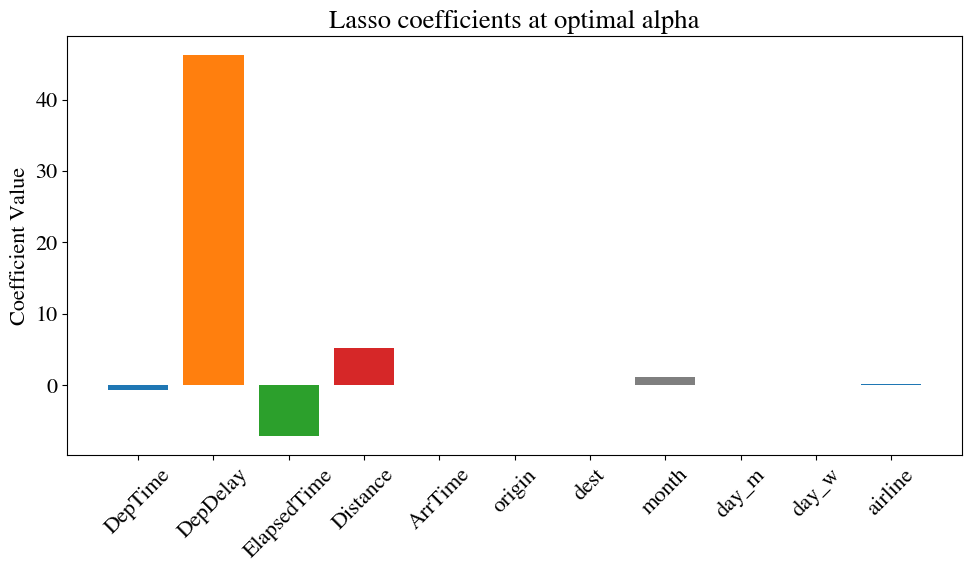

Optimal Alpha Value: 0.004620203458031631


In [8]:
# Group categorical columns by type and then take the mean of the coefficients for each group
from sklearn.linear_model import LassoCV

# Perform LassoCV
lasso_cv = LassoCV(cv=5, eps=1e-6, max_iter=10000, tol=0.01, random_state=42)
lasso_cv.fit(X_train_std, y_train.values.ravel())

# Get the coefficients
coefs = lasso_cv.coef_[np.newaxis, :]

# Create a DataFrame to make manipulation easier
coefs_df = pd.DataFrame(coefs, columns=X_train.columns)

# Function to simplify labels
def simplify_label(label):
    parts = label.split('_')
    if len(parts) > 1:
        if 'day_m' in label or 'day_w' in label:
            return f"{parts[0]}_{parts[1]}"
        else:
            return f"{parts[0]}"
    return label

# Simplify labels
simplified_labels = coefs_df.columns.to_series().apply(simplify_label).unique()

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through simplified labels to plot the coefficients
for label in simplified_labels:
    label_coefs = coefs_df.filter(regex=f'^{label}', axis=1)
    mean_coef = label_coefs.mean(axis=1)
    plt.bar(label, mean_coef)

# Customize plot
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients at optimal alpha')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
print("Optimal Alpha Value:", lasso_cv.alpha_)

In [26]:
### Notes and TODOs ### 
'''
Based on correlation matrix, we can see that there are some features that are highly correlated with each other: 
1. DepDelay and ArrDelay --- This makes sence because if a flight departs late, it's also very likely to arrive late. 
Since ArrDelay is the target variable for regression, we will 
    a. Drop DepDelay to avoid overshadowing the effect of other features. 
    b. Keep DepDelay to see if it's a good predictor for regression. 
    c. Feature engineer a new feature called 'ArrDepDiff' to see if it's a good predictor for regression. 
2. Distance and ElapsedTime --- This makes sence because the longer the distance of a flight, the longer it's expected to be in the air. 
Since they are highly correlated, we will drop one of them to reduce multicollinearity. We will test both and see which one leads to better model performance. 
    a. Drop Distance 
    b. Drop ElapsedTime  

Another interesting observation is that the importance of month is pretty high among all the categorical features. 
This implies the seasonality of flight delays. We will keep an eye on this feature and see if it's a good predictor for regression. 

Now, before building the regression model, we are going to do feature selection using decision tree, and compare the results with Lasso and correlation matrix. 
'''

# Decision tree for feature importance 

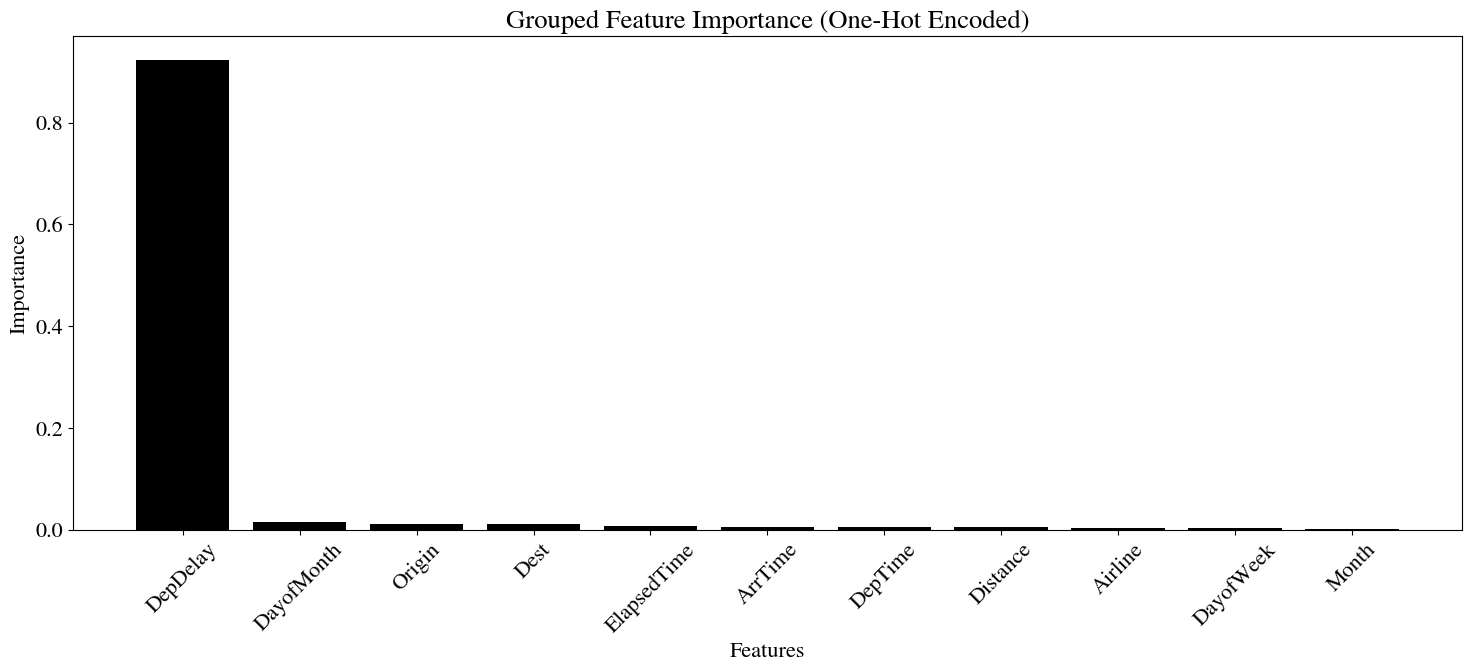

In [ ]:
# Feature importance of categorical features of the same type are accumulated 
from sklearn.tree import DecisionTreeRegressor

# Use the one-hot encoded / non-scaled data for training 
X_train_data = X_train
y_train_data = y_train.ravel()

# Training the Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_data, y_train_data)

# Get the feature importances
importances = dt.feature_importances_

# Group the feature importances
features = X_train_data.columns
importance_dict = {}
for feat, imp in zip(features, importances):
    # Check which category the feature belongs to
    if 'origin' in feat:
        category = 'Origin'
    elif 'dest' in feat:
        category = 'Dest'
    elif 'month' in feat:
        category = 'Month'
    elif 'day_m' in feat:
        category = 'DayofMonth'
    elif 'day_w' in feat:
        category = 'DayofWeek'
    elif 'airline' in feat:
        category = 'Airline'
    else:
        category = feat
        
    # Accumulate the importance for that category
    if category in importance_dict:
        importance_dict[category] += imp
    else:
        importance_dict[category] = imp

# Sorting the dictionary by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Plotting the grouped feature importances
plt.figure(figsize=(15,7))
plt.bar(*zip(*sorted_importances), color='k')
plt.title("Grouped Feature Importance (One-Hot Encoded)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


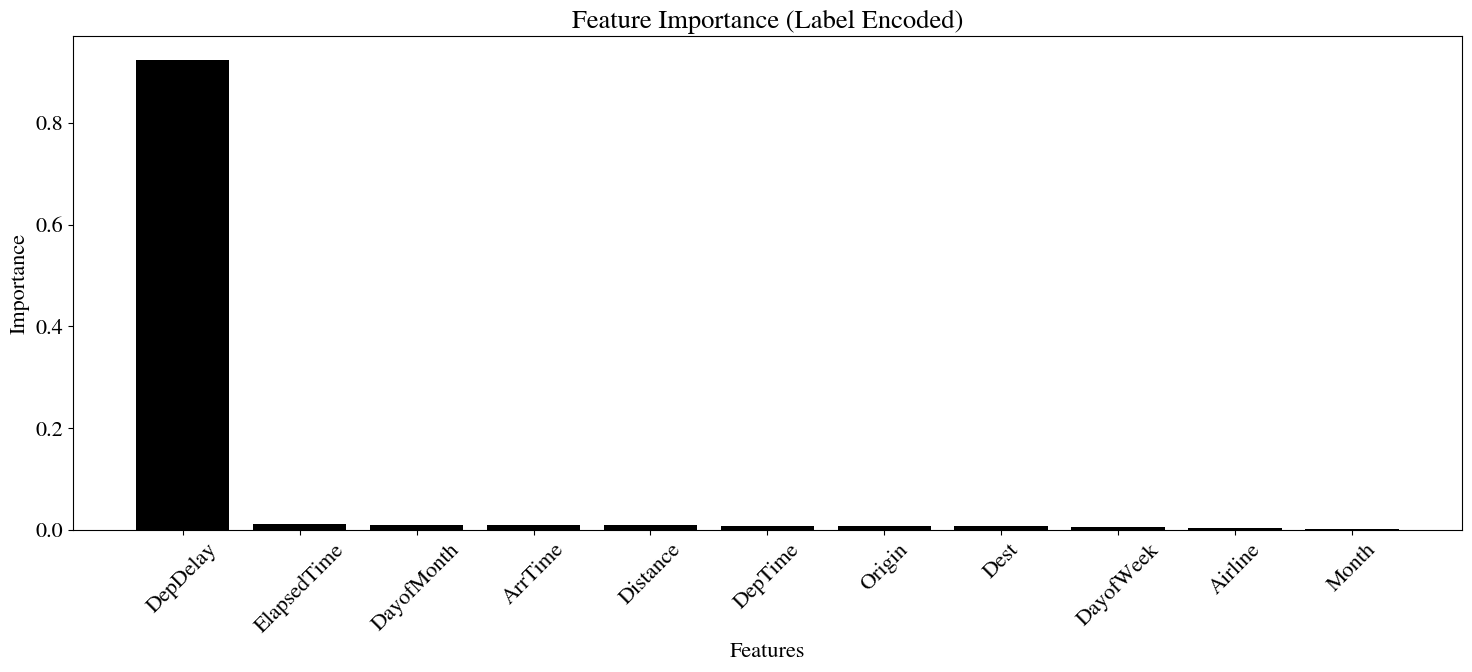

In [ ]:
### Label Encoding for Categorical Features 
from sklearn.preprocessing import LabelEncoder

# Create a copy of the original dataframe
df_label_encoded = df_raw.copy()

# Initialize a label encoder and apply it to the copy
label_encoders = {}

for col in ['Origin', 'Dest', 'Month', 'DayofMonth', 'DayofWeek', 'Airline']:
    le = LabelEncoder()
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])
    label_encoders[col] = le

# Use the label-encoded copy to define X and y
X = df_label_encoded.drop(columns=['ArrDelay', 'ArrGroup'])  
y = df_label_encoded['ArrDelay']                 

from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
# Use the label-encoded data for training 
X_train_data = X
y_train_data = y.ravel()

# Training the Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_data, y_train_data)

# Get the feature importances
importances = dt.feature_importances_

# Pair up the features and their corresponding importances
features = X_train_data.columns
feature_importance_pairs = list(zip(features, importances))

# Sort the feature importance pairs
sorted_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Plotting the feature importances
plt.figure(figsize=(15,7))
plt.bar(*zip(*sorted_importances), color='k')
plt.title("Feature Importance (Label Encoded)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
### Notes 
'''
Decision tree feature importance also suggests that DepDelay is the most important feature.
Interestingly, Month is not as important as it is in Lasso regression. 

Now, we are going to drop DepDelay and redo Lasso and Decision Tree feature importance to capture the importance of other features. 
'''

# After dropping `DepDelay`

In [2]:
X = df_new.drop(columns=['ArrDelay', 'ArrGroup', 'DepDelay'])
y = df_new['ArrDelay'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

numerical_columns = ['DepTime', 'ArrTime', 'ElapsedTime', 'Distance']
categorical_columns = X_train.columns.difference(numerical_columns)

standard_scaler = StandardScaler()

X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_val_std[numerical_columns] = standard_scaler.transform(X_val[numerical_columns])
X_test_std[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

y_train_std = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_std = standard_scaler.transform(y_val.values.reshape(-1, 1))
y_test_std = standard_scaler.transform(y_test.values.reshape(-1, 1))


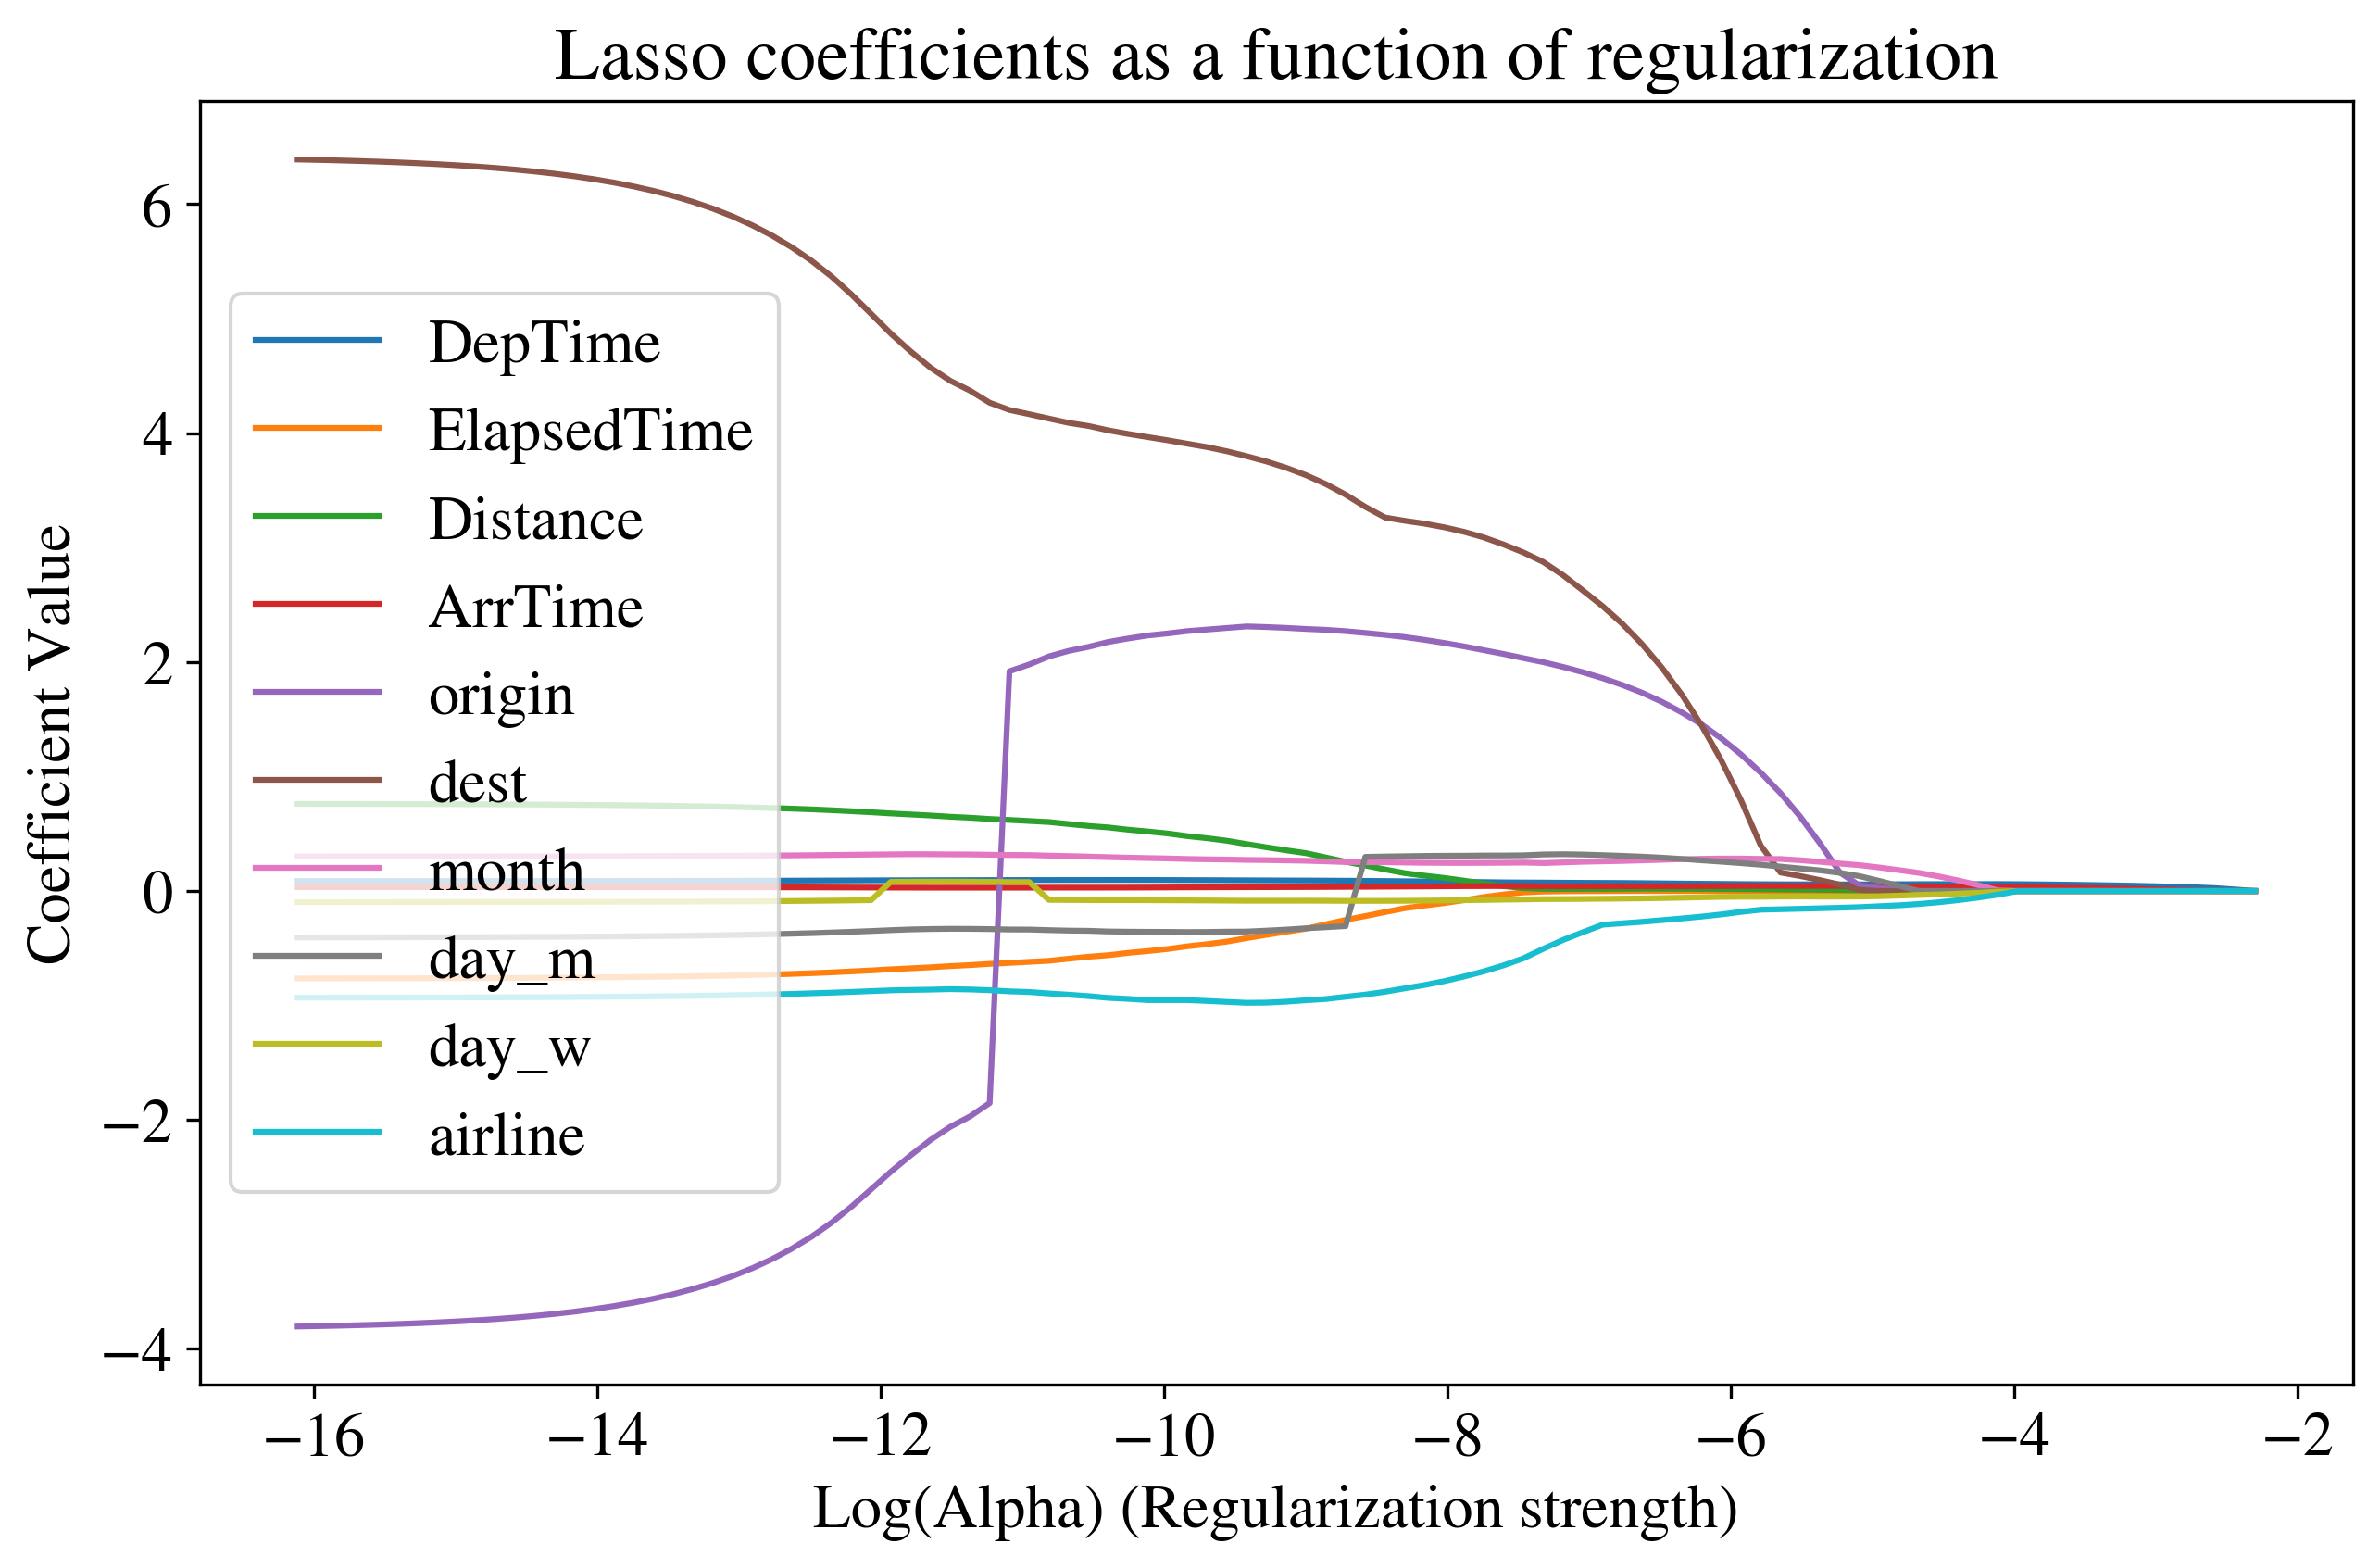

In [10]:
from sklearn.linear_model import lasso_path
# Use a small subset of X_train_std and y_train_std for testing the code
X_train_std_subset = X_train_std.iloc[:1000, :] 
y_train_std_subset = y_train_std[:1000]

# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_std_subset, y_train_std_subset.ravel(), eps=1e-6, max_iter=10000, tol=0.01)

# Create a DataFrame to make manipulation easier
coefs_df = pd.DataFrame(coefs_lasso, index=X_train_std_subset.columns)

# Function to simplify labels
def simplify_label(label):
    parts = label.split('_')
    if len(parts) > 1:
        if 'day_m' in label or 'day_w' in label:
            return f"{parts[0]}_{parts[1]}"
        else:
            return f"{parts[0]}"
    return label

# Simplify labels
simplified_labels = coefs_df.index.to_series().apply(simplify_label).unique()

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through simplified labels to plot the paths
for label in simplified_labels:
    label_coefs = coefs_df.filter(regex=f'^{label}', axis=0)
    
    # Get the index of the maximum absolute coefficient for each alpha
    idx_max_abs_coef = np.abs(label_coefs).idxmax(axis=0)
    
    # For each alpha, fetch the signed coefficient of the feature with the max absolute coefficient
    signed_max_coef = [label_coefs.at[feature, col] for feature, col in zip(idx_max_abs_coef, label_coefs.columns)]
    
    plt.plot(np.log(alphas_lasso), signed_max_coef, label=label)

# Customize plot
plt.xlabel('Log(Alpha) (Regularization strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a function of regularization')
plt.legend()
plt.axis('tight')

plt.show()


In [23]:
### Read dataset ---------------------------------------------------------------
# Drop DepDelay 
X = df_new.drop(columns=['ArrDelay', 'ArrGroup', 'DepDelay'])
y = df_new['ArrDelay'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

numerical_columns = ['DepTime', 'ArrTime', 'ElapsedTime', 'Distance']
categorical_columns = X_train.columns.difference(numerical_columns)

standard_scaler = StandardScaler()

X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_val_std[numerical_columns] = standard_scaler.transform(X_val[numerical_columns])
X_test_std[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

y_train_std = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_std = standard_scaler.transform(y_val.values.reshape(-1, 1))
y_test_std = standard_scaler.transform(y_test.values.reshape(-1, 1))

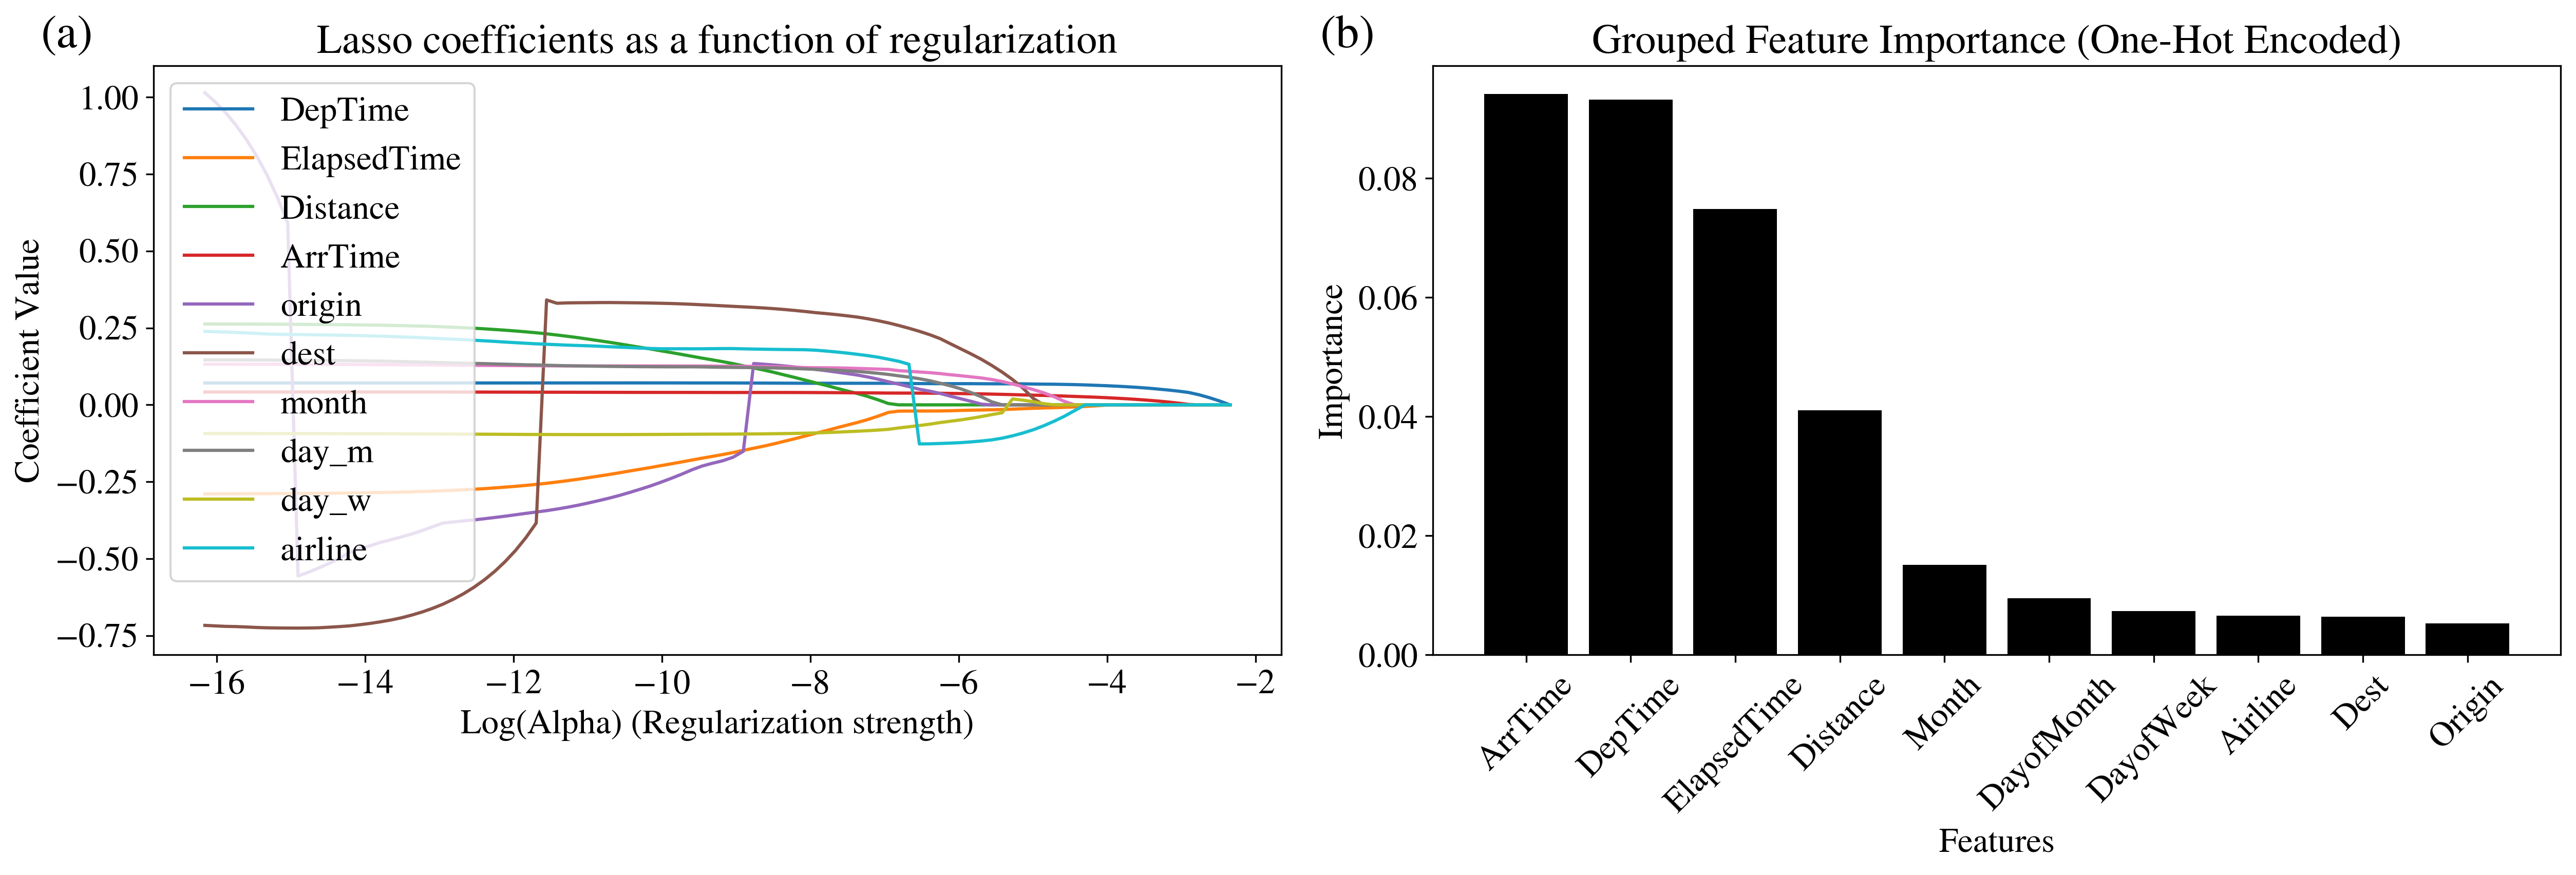

In [20]:
### Thia cell plot the subcategory of categorical features with maximum absolute coefficient for each alpha 
### This is just for estimation, not the final result 

# X_train_std = X_train_std.iloc[:100, :]
# y_train_std = y_train_std[:100]

from sklearn.linear_model import lasso_path
# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_std, y_train_std.ravel(), eps=1e-6, max_iter=10000, tol=0.01)

# Create a DataFrame to make manipulation easier
coefs_df = pd.DataFrame(coefs_lasso, index=X_train_std.columns)

# Function to simplify labels
def simplify_label(label):
    parts = label.split('_')
    if len(parts) > 1:
        if 'day_m' in label or 'day_w' in label:
            return f"{parts[0]}_{parts[1]}"
        else:
            return f"{parts[0]}"
    return label

# Simplify labels
simplified_labels = coefs_df.index.to_series().apply(simplify_label).unique()

# Initialize plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6)) 


# Loop through simplified labels to plot the paths
for label in simplified_labels:
    label_coefs = coefs_df.filter(regex=f'^{label}', axis=0)
    
    # Get the index of the maximum absolute coefficient for each alpha
    idx_max_abs_coef = np.abs(label_coefs).idxmax(axis=0)
    
    # For each alpha, fetch the signed coefficient of the feature with the max absolute coefficient
    signed_max_coef = [label_coefs.at[feature, col] for feature, col in zip(idx_max_abs_coef, label_coefs.columns)]
    
    ax[0].plot(np.log(alphas_lasso), signed_max_coef, label=label)

# Customize plot
ax[0].set_xlabel('Log(Alpha) (Regularization strength)')
ax[0].set_ylabel('Coefficient Value')
ax[0].set_title('Lasso coefficients as a function of regularization')
ax[0].text(-0.1, 1.05, '(a)', transform=ax[0].transAxes, fontsize=22, va='center')
ax[0].legend()


### Decision Tree Feature Importance ------------------------------------------- 
from sklearn.tree import DecisionTreeRegressor
# Use the one-hot encoded / non-scaled data for training 
X_train_data = X_train
y_train_data = y_train.ravel()

# X_train_data = X_train_data.iloc[:100, :]
# y_train_data = y_train_data[:100]

# Training the Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_data, y_train_data)

# Get the feature importances
importances = dt.feature_importances_

# Group the feature importances
features = X_train_data.columns
importance_dict = {}
for feat, imp in zip(features, importances):
    # Check which category the feature belongs to
    if 'origin' in feat:
        category = 'Origin'
    elif 'dest' in feat:
        category = 'Dest'
    elif 'month' in feat:
        category = 'Month'
    elif 'day_m' in feat:
        category = 'DayofMonth'
    elif 'day_w' in feat:
        category = 'DayofWeek'
    elif 'airline' in feat:
        category = 'Airline'
    else:
        category = feat
    
    # Instead of summing up the importance, we should take the max of the absolute value of the importance.
    if category in importance_dict:
        importance_dict[category] = max(importance_dict[category], np.abs(imp))
    else:
        importance_dict[category] = np.abs(imp)

# Sorting the dictionary by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Plotting the grouped feature importances

ax[1].bar(*zip(*sorted_importances), color='k')
ax[1].set_title("Grouped Feature Importance (One-Hot Encoded)")
ax[1].set_xlabel("Features")
ax[1].set_ylabel("Importance")
ax[1].set_xticks([i for i, _ in enumerate(sorted_importances)])
ax[1].set_xticklabels([label for label, _ in sorted_importances], rotation=45)
ax[1].text(-0.1, 1.05, '(b)', transform=ax[1].transAxes, fontsize=22, va='center')

plt.tight_layout()
plt.show()

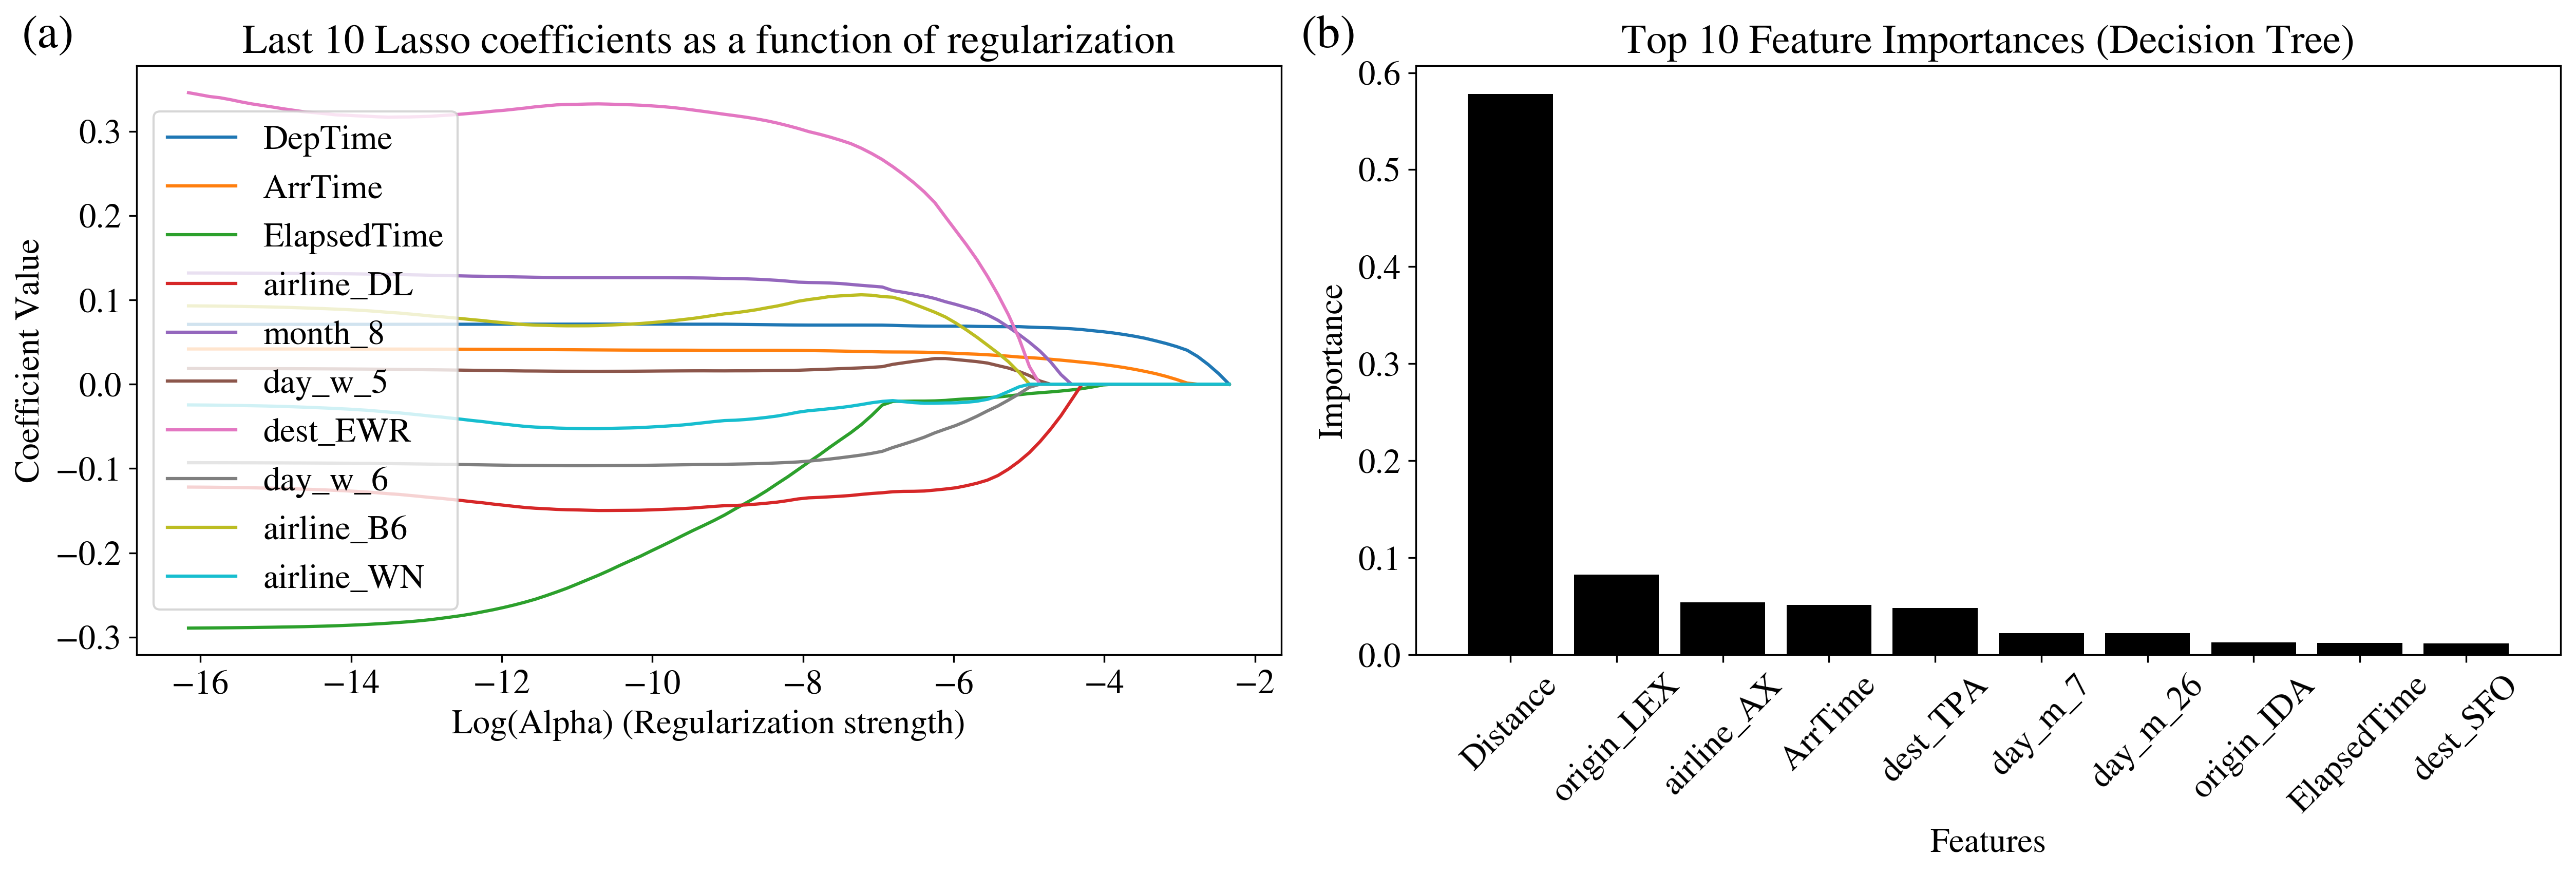

In [25]:
### Calculate the whole dataset feature importance, but just show the top 10 features 

from sklearn.linear_model import lasso_path
from sklearn.tree import DecisionTreeRegressor

# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_std, y_train_std.ravel(), eps=1e-6, max_iter=10000, tol=0.01)

# Create a DataFrame to make manipulation easier
coefs_df = pd.DataFrame(coefs_lasso, index=X_train_std.columns)

# Initialize plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6)) 

# For each feature, find the last alpha before the coefficient becomes zero
last_nonzero_alphas = {}
for feature, coefficients in coefs_df.iterrows():
    nonzero_coefs = alphas_lasso[np.abs(coefficients) > 1e-6]  # Avoid tiny values, treat them as zero
    if nonzero_coefs.size > 0:
        last_nonzero_alphas[feature] = np.max(nonzero_coefs)

# Get the 10 features with the highest last non-zero alpha
top_lasting_features = sorted(last_nonzero_alphas, key=last_nonzero_alphas.get, reverse=True)[:10]

# Plotting the long lasting last 10 Lasso coefficients
for feature in top_lasting_features:
    ax[0].plot(np.log(alphas_lasso), coefs_df.loc[feature], label=feature)


# Customize plot for Lasso coefficients
ax[0].set_xlabel('Log(Alpha) (Regularization strength)')
ax[0].set_ylabel('Coefficient Value')
ax[0].set_title('Last 10 Lasso coefficients as a function of regularization')
ax[0].text(-0.1, 1.05, '(a)', transform=ax[0].transAxes, fontsize=22, va='center')
ax[0].legend(loc='center left') 


# Train Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_data, y_train_data)

# Get feature importances and sort them
feature_importances = list(zip(X_train_data.columns, dt.feature_importances_))
sorted_features = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Plot top 10 feature importances for Decision Tree
top_features, top_importances = zip(*sorted_features[:10])
ax[1].bar(top_features, top_importances, color='k')
ax[1].set_title("Top 10 Feature Importances (Decision Tree)")
ax[1].set_xlabel("Features")
ax[1].set_ylabel("Importance")
ax[1].set_xticks(range(len(top_features)))
ax[1].set_xticklabels(top_features, rotation=45)
ax[1].text(-0.1, 1.05, '(b)', transform=ax[1].transAxes, fontsize=22, va='center')

plt.tight_layout()
plt.show()

In [20]:
### Notes 
'''
We can see that after dropping the dominating feature DepDelay, the importance of other features are more evenly distributed. 
However, the ranking of features are quite different between Lasso and Decision Tree. 
Therefore, we compute permutation importance for both Lasso and Decision Tree to see if we can get more consistent results. 

Note that the cons of permutation importance is that it's computationally expensive. 
'''

### Permutation Importance for Lasso ---------------------------------------------------------------
from sklearn.inspection import permutation_importance

# Lasso Model ------------------------------------------------------------------ 
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000) # using 5-fold cross-validation as an example

lasso_cv.fit(X_train_std, y_train_std.ravel()) # fit the model 

optimal_alpha = lasso_cv.alpha_ # Extract the optimal alpha
print(f"Optimal Alpha for Lasso: {optimal_alpha}")

from sklearn.linear_model import Lasso 
lasso = Lasso(alpha=optimal_alpha)  # assuming you have found an optimal alpha elsewhere in your code
lasso.fit(X_train_std, y_train_std.ravel())

# Permutation importance for Lasso model
perm_importance_lasso = permutation_importance(lasso, X_val_std, y_val_std.ravel(), n_repeats=30, random_state=42)

# Sorting indices
sorted_idx_lasso = perm_importance_lasso.importances_mean.argsort()

# Plotting permutation importance for Lasso
plt.figure(figsize=(12, 8))
plt.barh(X_train.columns[sorted_idx_lasso], perm_importance_lasso.importances_mean[sorted_idx_lasso])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance (Lasso Model)")
plt.show()

# Permutation importance for Decision Tree model ---------------------------------------------------  
perm_importance_dt = permutation_importance(dt, X_val, y_val, n_repeats=30, random_state=42)

# Sorting indices
sorted_idx_dt = perm_importance_dt.importances_mean.argsort()

# Plotting permutation importance for Decision Tree
plt.figure(figsize=(12, 8))
plt.barh(X_train_data.columns[sorted_idx_dt], perm_importance_dt.importances_mean[sorted_idx_dt])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance (Decision Tree Model)")
plt.show()

Optimal Alpha for Lasso: 4.76857707210552e-05


KeyboardInterrupt: 

# Model 1 - Linear regression 

In [6]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

## Lasso

In [9]:
'''
This code will run into memory issues since categorical features are one-hot encoded, leading to a large number of features when the polynomial degree is high. 
Therefore, we will only use degree 1 with finer alpha values to find the optimal alpha. 
''' 

# Define the model
lasso = Lasso()

# Define hyperparameters for grid search
param_grid_lasso = {
    'polynomialfeatures__degree': [1, 2],  # degrees of the polynomial features
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]  # regularization strength
}

# Define the pipeline, including polynomial feature transformation and Lasso regression for standardized data
pipeline_lasso_std = make_pipeline(PolynomialFeatures(), lasso)

# Set up the grid search for standardized data
grid_lasso_std = GridSearchCV(pipeline_lasso_std, param_grid_lasso, cv=5)

# Fit the model for standardized data
grid_lasso_std.fit(X_train_std, y_train_std)

# Print the best parameters found for standardized data
print("Best parameters for Lasso (Standardized): ", grid_lasso_std.best_params_)

# Make predictions for standardized data
y_pred_lasso_std = grid_lasso_std.predict(X_val_std)

# Calculate Mean Squared Error for standardized data
mse_lasso_std = mean_squared_error(y_val_std, y_pred_lasso_std)
print("Mean Squared Error for Lasso (Standardized): ", mse_lasso_std)


In [11]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the model
lasso = Lasso()

# Generate a sequence of alphas spaced evenly on a log scale between 10^-4 to 10^1
alphas = np.logspace(-4, 1, 20)  

# Define hyperparameters for grid search
param_grid_lasso = {
    'alpha': alphas  # regularization strength
}

# Set up the grid search for standardized data
grid_lasso_std = GridSearchCV(lasso, param_grid_lasso, cv=5)

# Fit the model for standardized data
grid_lasso_std.fit(X_train_std, y_train_std)

# Print the best parameters found for standardized data
print("Best parameters for Lasso (Standardized): ", grid_lasso_std.best_params_)

# Make predictions for standardized data
y_pred_lasso_std = grid_lasso_std.predict(X_val_std)

# Calculate Mean Squared Error for standardized data
mse_lasso_std = mean_squared_error(y_val_std, y_pred_lasso_std)
print("Mean Squared Error for Lasso (Standardized): ", mse_lasso_std)


Best parameters for Lasso (Standardized):  {'alpha': 9.999999999999999e-05}
Mean Squared Error for Lasso (Standardized):  0.9714979769012652


# Visualization 

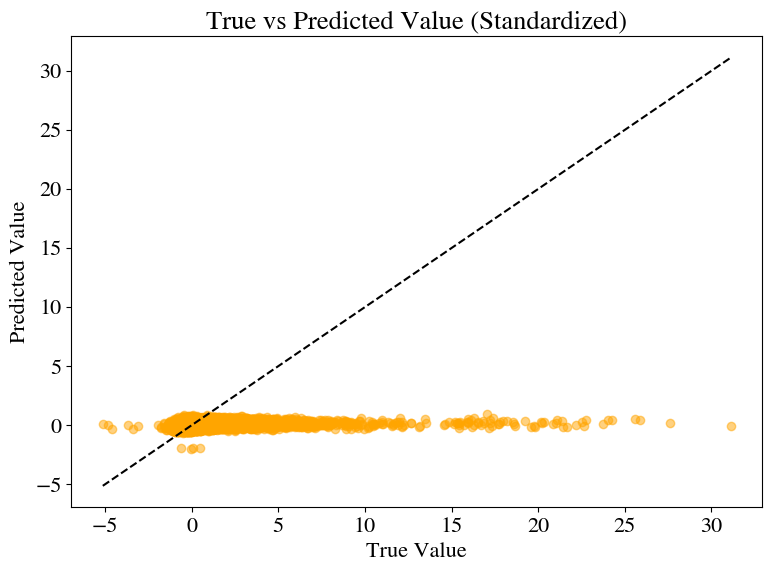

In [12]:
### True vs. Predicted 

'''
If every predicted value matches the actual value, all points would lie on a 45-degree line, 
often called the "line of perfect fit" or "identity line". This line usually starts from the origin and has a slope of 1. 
If the points are scattered widely around this line, it suggests that there are larger discrepancies between the predicted and actual values.
'''

fig, ax = plt.subplots(figsize=(8, 6)) 
ax.scatter(y_val_std, y_pred_lasso_std, alpha=0.5, color='orange')
ax.plot([y_val_std.min(), y_val_std.max()], [y_val_std.min(), y_val_std.max()], '--k')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.set_title('True vs Predicted Value (Standardized)')

plt.tight_layout()
plt.show()

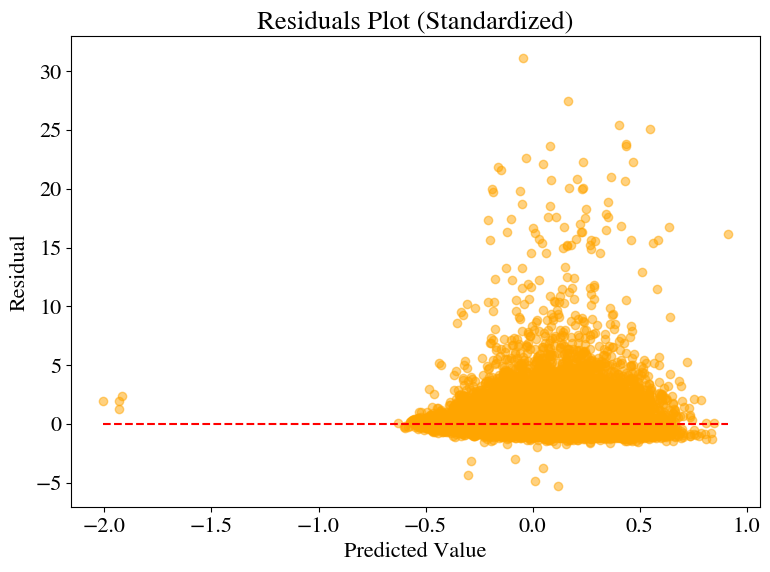

In [16]:
### Residuals Plot

'''
If residuals are randomly scattered around the horizontal axis, then it's a good sign. 
It means the model has an equal chance of overestimating and underestimating the target variable. 
However, observing any clear pattern (e.g., a curve), might indicate that the model is not capturing some underlying pattern in the data. 
'''

fig, ax = plt.subplots(figsize=(8, 6))
y_val_std = y_val_std.ravel()
ax.scatter(y_pred_lasso_std, y_val_std - y_pred_lasso_std, alpha=0.5, color='orange')
ax.hlines(0, y_pred_lasso_std.min(), y_pred_lasso_std.max(), colors='r', linestyles='--')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Residual')
ax.set_title('Residuals Plot (Standardized)')

plt.tight_layout()
plt.show()


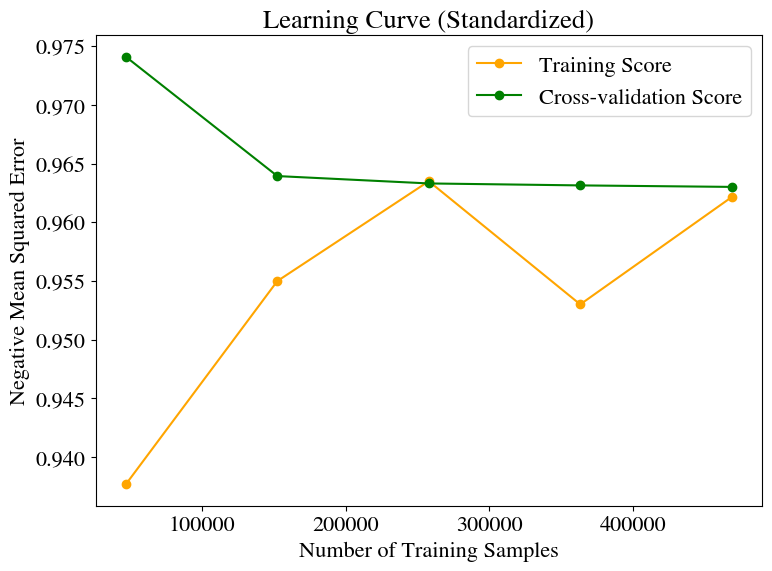

In [14]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

### Learning Curve 
'''
A learning curve is a graphical representation of how an algorithm's performance changes as a function of the amount of data it's trained on. 
The graph allows you to understand the relationship between the model's experience (in terms of number of training samples) 
and its proficiency (usually in terms of accuracy or some error metric). 
'''


fig, ax = plt.subplots(figsize=(8, 6))

# Specify scoring as negative mean squared error
train_sizes, train_scores, validation_scores = learning_curve(grid_lasso_std.best_estimator_, X_train_std, y_train_std, cv=5, scoring='neg_mean_squared_error')

ax.plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training Score', color='orange')
ax.plot(train_sizes, -validation_scores.mean(axis=1), 'o-', label='Cross-validation Score', color='green')
ax.set_xlabel('Number of Training Samples')
ax.set_ylabel('Negative Mean Squared Error') 
ax.set_title('Learning Curve (Standardized)')
ax.legend() 

plt.tight_layout()
plt.show()

## Ridge 

In [ ]:
# Define the model
ridge = Ridge()

# Define hyperparameters for grid search
param_grid_ridge = {
    'polynomialfeatures__degree': [1, 2],  # degrees of the polynomial features
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10]  # regularization strength
}

# ----------------- For Normalized Data -----------------
# Define the pipeline, including polynomial feature transformation and Ridge regression for normalized data
pipeline_ridge_norm = make_pipeline(PolynomialFeatures(), ridge)

# Set up the grid search for normalized data
grid_ridge_norm = GridSearchCV(pipeline_ridge_norm, param_grid_ridge, cv=5)

# Fit the model for normalized data
grid_ridge_norm.fit(X_train_norm, y_train_norm)

# Print the best parameters found for normalized data
print("Best parameters for Ridge (Normalized): ", grid_ridge_norm.best_params_)

# Make predictions for normalized data
y_pred_ridge_norm = grid_ridge_norm.predict(X_val_norm)

# Calculate Mean Squared Error for normalized data
mse_ridge_norm = mean_squared_error(y_val_norm, y_pred_ridge_norm)
print("Mean Squared Error for Ridge (Normalized): ", mse_ridge_norm)

# ----------------- For Standardized Data -----------------
# Define the pipeline, including polynomial feature transformation and Ridge regression for standardized data
pipeline_ridge_std = make_pipeline(PolynomialFeatures(), ridge)

# Set up the grid search for standardized data
grid_ridge_std = GridSearchCV(pipeline_ridge_std, param_grid_ridge, cv=5)

# Fit the model for standardized data
grid_ridge_std.fit(X_train_std, y_train_std)

# Print the best parameters found for standardized data
print("Best parameters for Ridge (Standardized): ", grid_ridge_std.best_params_)

# Make predictions for standardized data
y_pred_ridge_std = grid_ridge_std.predict(X_val_std)

# Calculate Mean Squared Error for standardized data
mse_ridge_std = mean_squared_error(y_val_std, y_pred_ridge_std)
print("Mean Squared Error for Ridge (Standardized): ", mse_ridge_std)


# Decision Tree 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Initialize the DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Fit the model on the standardized training data
dt_regressor.fit(X_train_std, y_train_std.ravel())

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on the validation set
y_val_pred = dt_regressor.predict(X_val_std)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_val_std, y_val_pred)
mse = mean_squared_error(y_val_std, y_val_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

# Initialize a Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)

# Specify hyperparameters and their possible values
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],   # You can adjust these values based on your understanding or leave as is.
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'splitter': ['best', 'random']
}

# Using GridSearchCV to search for best hyperparameters
# GridSearchCV will use cross-validation and try all combinations of hyperparameters to find the best one.
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
# Using negative mean squared error as scoring. For regression, it's common to use negative MSE as a score 
# because GridSearchCV tries to maximize the score.

# Fit the model to training data
grid_search.fit(X_train_std, y_train_std.ravel())

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
best_tree = grid_search.best_estimator_

# Predict on validation data
y_val_pred = best_tree.predict(X_val_std)

# Metrics for validation data
val_mse = mean_squared_error(y_val_std, y_val_pred)
val_mae = mean_absolute_error(y_val_std, y_val_pred)
val_r2 = r2_score(y_val_std, y_val_pred)

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R^2: {val_r2:.4f}")

# Predict on test data
y_test_pred = best_tree.predict(X_test_std)

# Metrics for test data
test_mse = mean_squared_error(y_test_std, y_test_pred)
test_mae = mean_absolute_error(y_test_std, y_test_pred)
test_r2 = r2_score(y_test_std, y_test_pred)

print(f"\nTest MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")


# Random Forest 